# **Tranquility score** calculation

# Intro

### Objectives
- reliably determine valid increases in long-term stress levels
- distinct between valid stress increase (alert) and false positive (log and learn)
- classify into 3 types of MS (eventually)



### Libraries
- NumPy, SciPy, Keras, TensorFlow, Pandas
- [HeartPy](https://pypi.org/project/heartpy/)
- [Python waveform-database (WFDB)](https://wfdb.readthedocs.io/en/latest/) 
- [Python Heart Rate Analysis Package](https://github.com/paulvangentcom/heartrate_analysis_python) 

In [0]:
# install missing libs for Colab
!pip install wfdb heartpy

In [0]:
# increase plot DPI

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['figure.dpi'] = 150

### Data sources
- [HeartPy sample data](https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/heartpy.heartpy.html#heartpy.load_exampledata) 
- [PhysioNet wrist PPG excercise dataset](https://physionet.org/content/wrist/1.0.0/) 
- [BIDMC PPG and Respiration Dataset](https://physionet.org/content/bidmc/1.0.0/)

### References
- Oura HRV [basics](https://ouraring.com/heart-rate-variability-basics/), [details](https://ouraring.com/how-to-measure-heart-rate-variability/) and [white paper](https://d1a0efioav7lro.cloudfront.net/wp-content/uploads/2018/10/23112753/The-HRV-of-the-Ring-Comparison-of-OURA-Ring-to-ECG.pdf) 
- [An innovative peak detection algorithm for photoplethysmography signals: an adaptive segmentation method](https://www.researchgate.net/publication/299593684_An_innovative_peak_detection_algorithm_for_photoplethysmography_signals_An_adaptive_segmentation_method)
- [Assessing mental stress from the photoplethysmogram: a numerical study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5964362/)
- [Stress and Heart Rate Variability: A Meta-Analysis and Review of the Literature](https://www.ncbi.nlm.nih.gov/pubmed/29486547)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

*Jump directly to **HeartPy playground** if you're interested in the final calculations*

# Playground 1

- data from google drive

In [0]:
import pandas as pd
import keras

In [0]:
rootPath = "/content/drive/My Drive/ppg_data/wrist-ppg-during-exercise-1.0.0/"

In [0]:
f = open(rootPath + "ANNOTATORS", "r", encoding="utf-8")

In [23]:
pd.Series(f)

0    atr\tReference ECG peaks
dtype: object

In [0]:
import wfdb

In [0]:
tpath = rootPath + "s1_high_resistance_bike"

In [0]:
f = open(tpath+".dat", "r", encoding="utf-8")

In [0]:
rec = wfdb.io.rdrecord(tpath)

In [30]:
subrec = wfdb.rdann(tpath, 'dat')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [36]:
rec.p_signal.shape

(150785, 15)

In [35]:
subrec

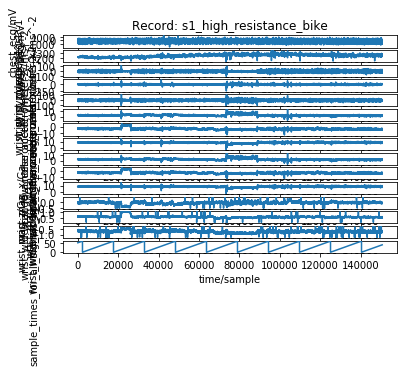

In [0]:
wfdb.plot_wfdb(rec)

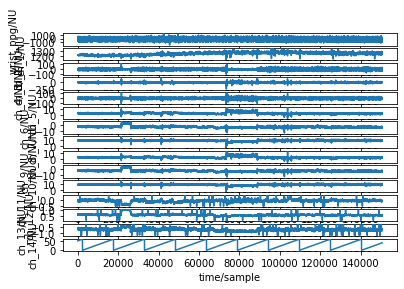

In [42]:
wfdb.plot_items(rec.p_signal, sig_name=["wrist_ppg"])

In [45]:
len(rec.sig_name)

15

In [0]:
display(rec.__dict__)

{'adc_gain': [21.6691,
  297.5305,
  302.2647,
  163.6502,
  289.0765,
  3420.4251,
  3957.3531,
  3704.5378,
  3509.8327,
  4038.253,
  3907.18,
  73380.1255,
  68761.9758,
  61349.3142,
  1092.3062],
 'adc_res': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'adc_zero': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'base_counter': None,
 'base_date': None,
 'base_time': None,
 'baseline': [5670,
  -367431,
  -2934,
  5931,
  -971,
  -11434,
  16154,
  -23048,
  -11704,
  16500,
  -24829,
  3872,
  -39979,
  46294,
  -32770],
 'block_size': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'byte_offset': [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'checksum': [12366,
  -13854,
  30678,
  24454,
  1414,
  76,
  11602,
  630,
  5925,
  -6008,
  19339,
  -18710,
  -7732,
  878,
  -4634],
 'comments': ['High resistance biking_level 6'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal'

# Data playground

- wfdb data load
- heartpy processing

In [0]:
header = wfdb.rdheader('s1_high_resistance_bike', pb_dir='wrist')
record = wfdb.rdrecord('s1_high_resistance_bike', pb_dir='wrist', sampfrom=20000, sampto=21000)

In [82]:
header.__dict__['sig_name']

['chest_ecg',
 'wrist_ppg',
 'wrist_gyro_x',
 'wrist_gyro_y',
 'wrist_gyro_z',
 'wrist_low_noise_accelerometer_x',
 'wrist_low_noise_accelerometer_y',
 'wrist_low_noise_accelerometer_z',
 'wrist_wide_range_accelerometer_x',
 'wrist_wide_range_accelerometer_y',
 'wrist_wide_range_accelerometer_z',
 'wrist_mag_x',
 'wrist_mag_y',
 'wrist_mag_z',
 'sample_times_for_all_signals_apart_from_ecg']

In [119]:
record.p_signal[:,1].shape

(1000,)

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['figure.dpi'] = 150


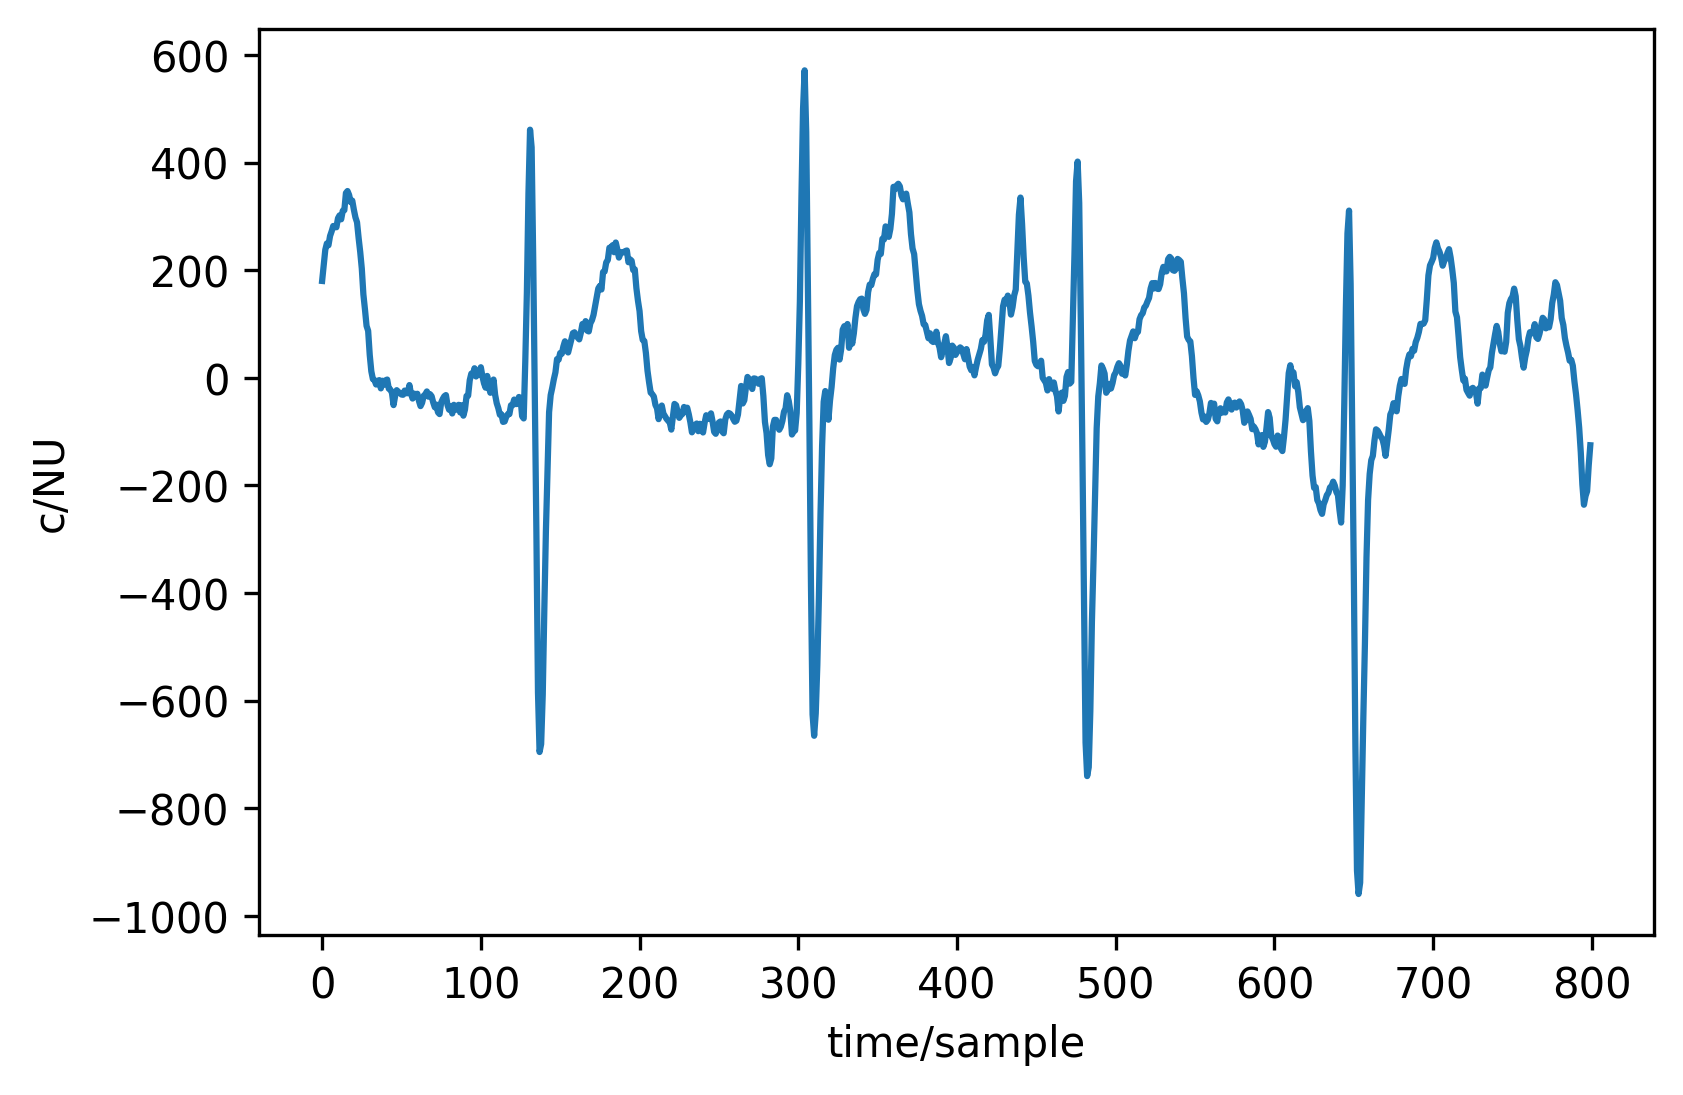

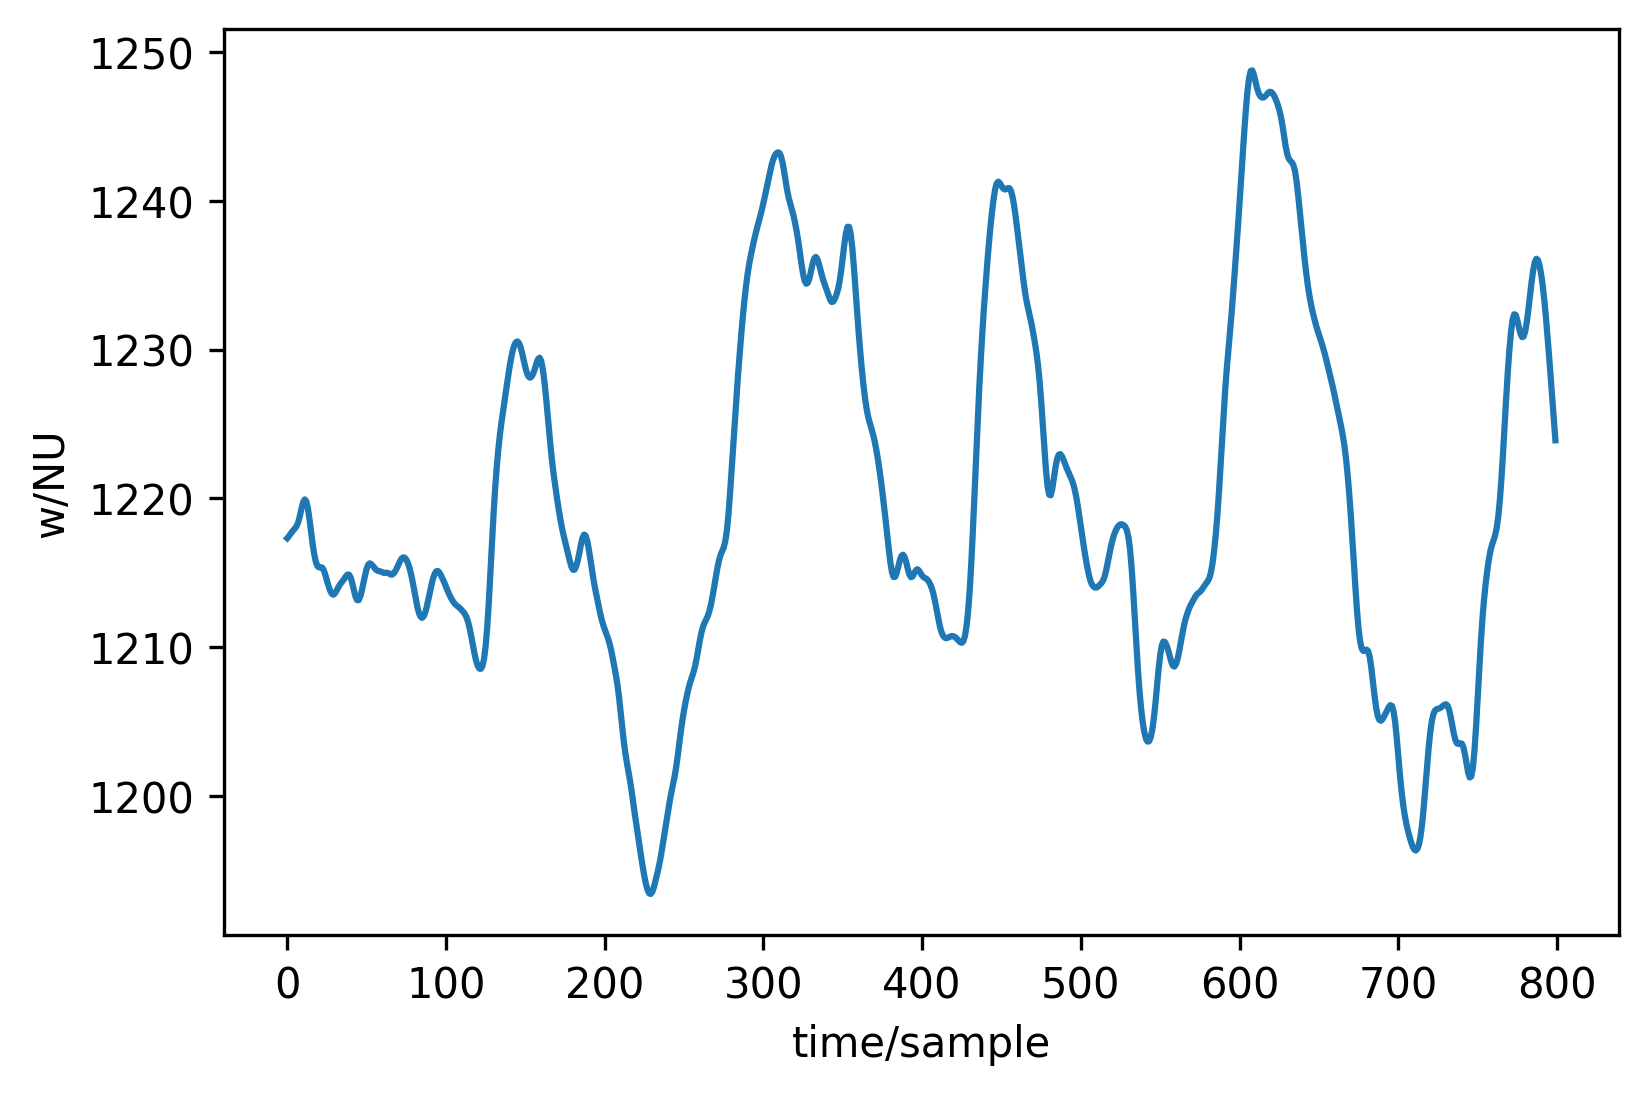

In [88]:
wfdb.plot_items(record.p_signal[:,0], sig_name='chest_ecg')
wfdb.plot_items(record.p_signal[:,1], sig_name='wrist_ppg')

In [0]:
import numpy as np

In [0]:
normalized = np.multiply(np.subtract(record.p_signal[:,1], 1220), 30)

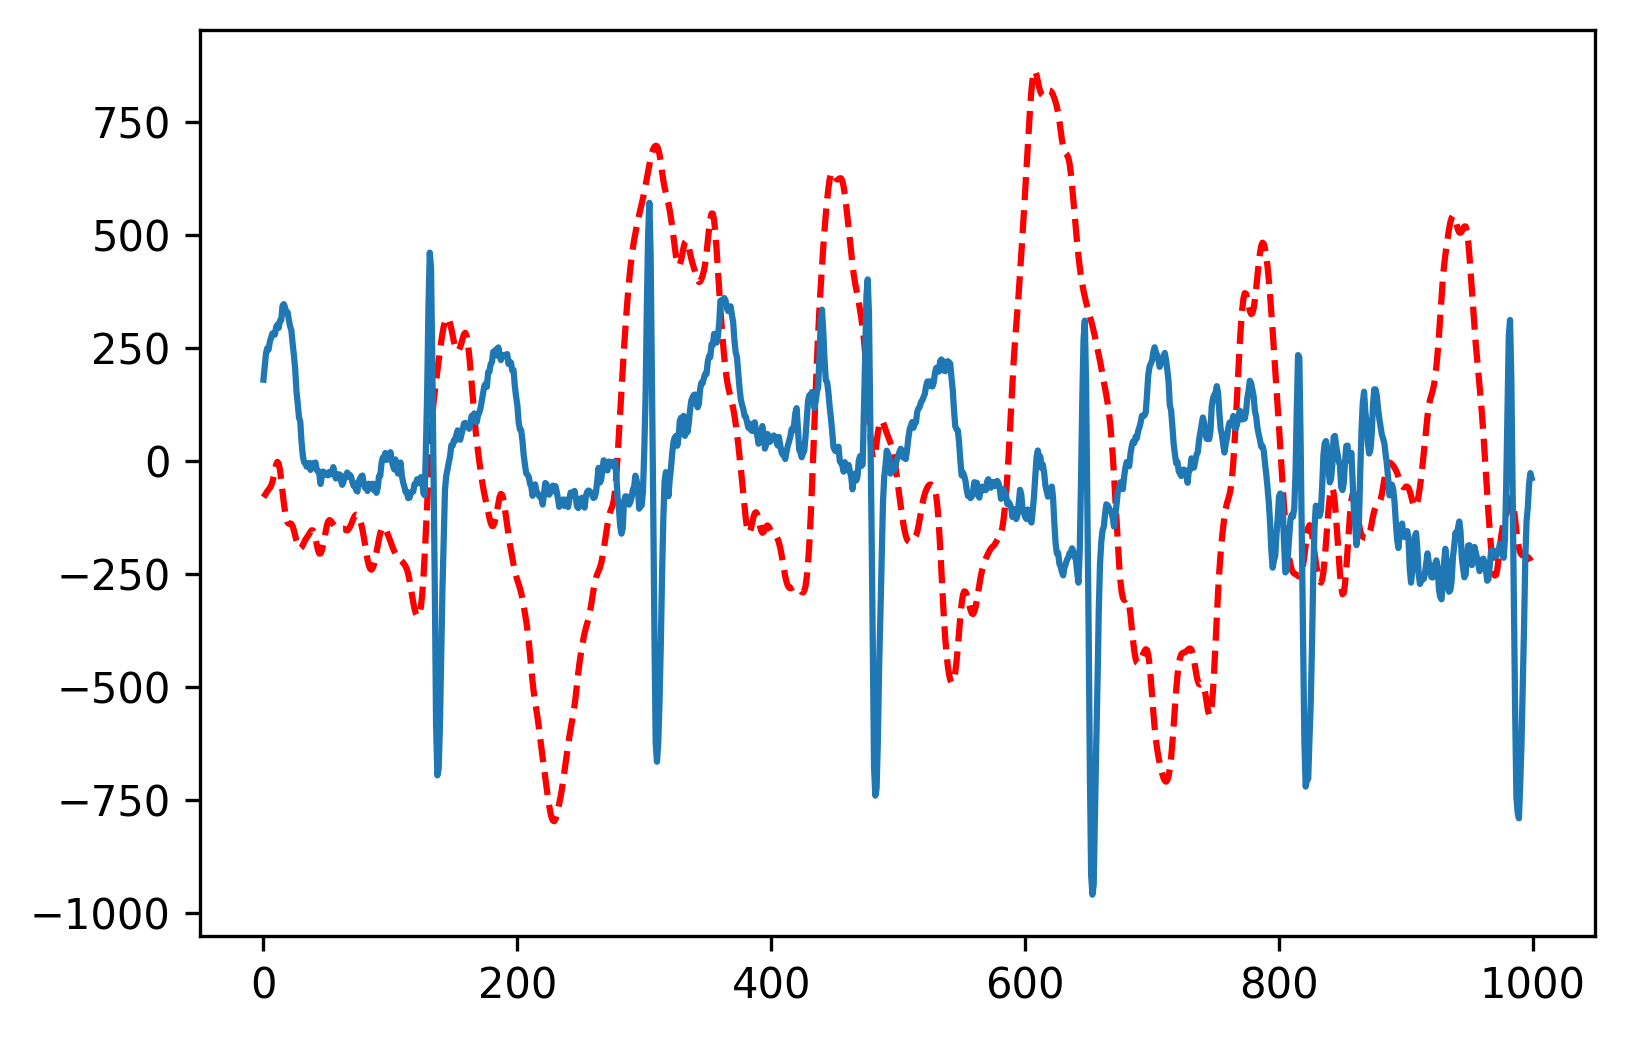

In [111]:
# overlap PPG and ECG data from wrist tracking
plt.plot(normalized, "r--", record.p_signal[:,0])
plt.show()

In [126]:
data=record.p_signal[:,1]
print(np.var(data))
print(np.min(data))
print(np.max(data))
print(np.std(data))

141.16213015245793
1193.427228469014
1248.766092887956
11.881167036636509


In [0]:
type='s1_high_resistance_bike'
def displaySamples(x=0):
  record = wfdb.rdrecord(type, pb_dir='wrist', sampfrom=x, sampto=x+1000)
  wfdb.plot_items(record.p_signal[:,1], sig_name='wrist_ppg')


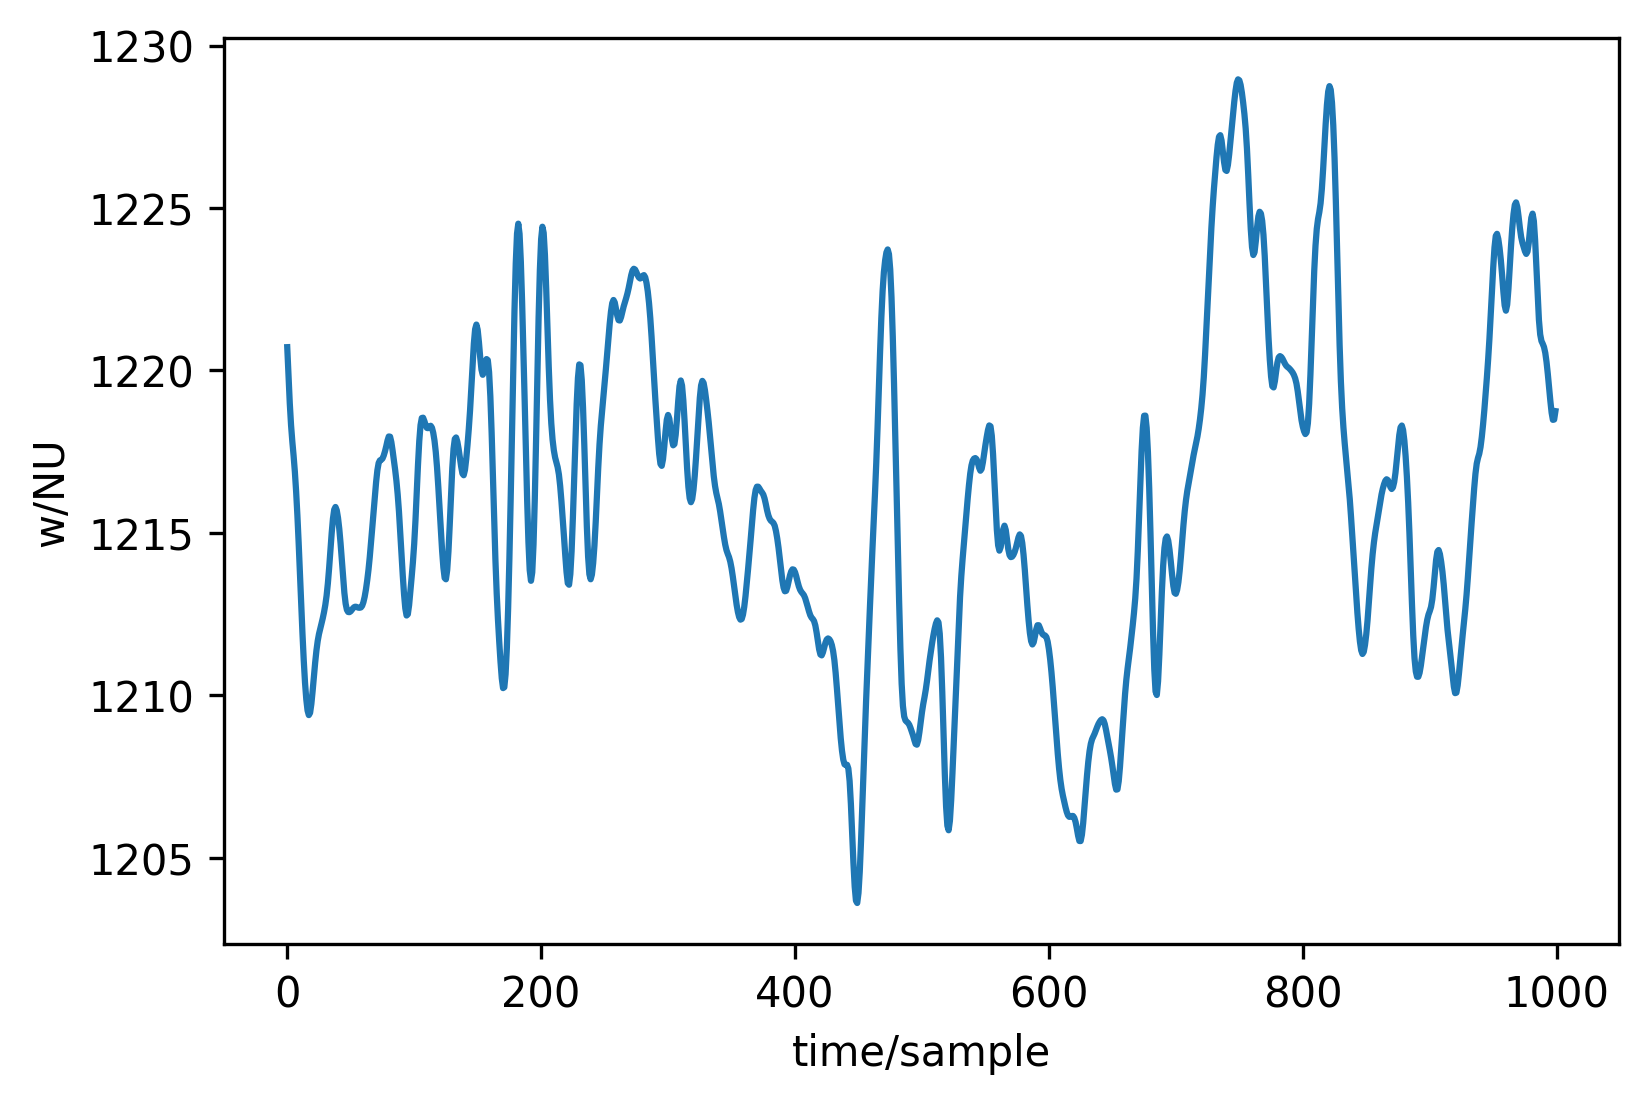

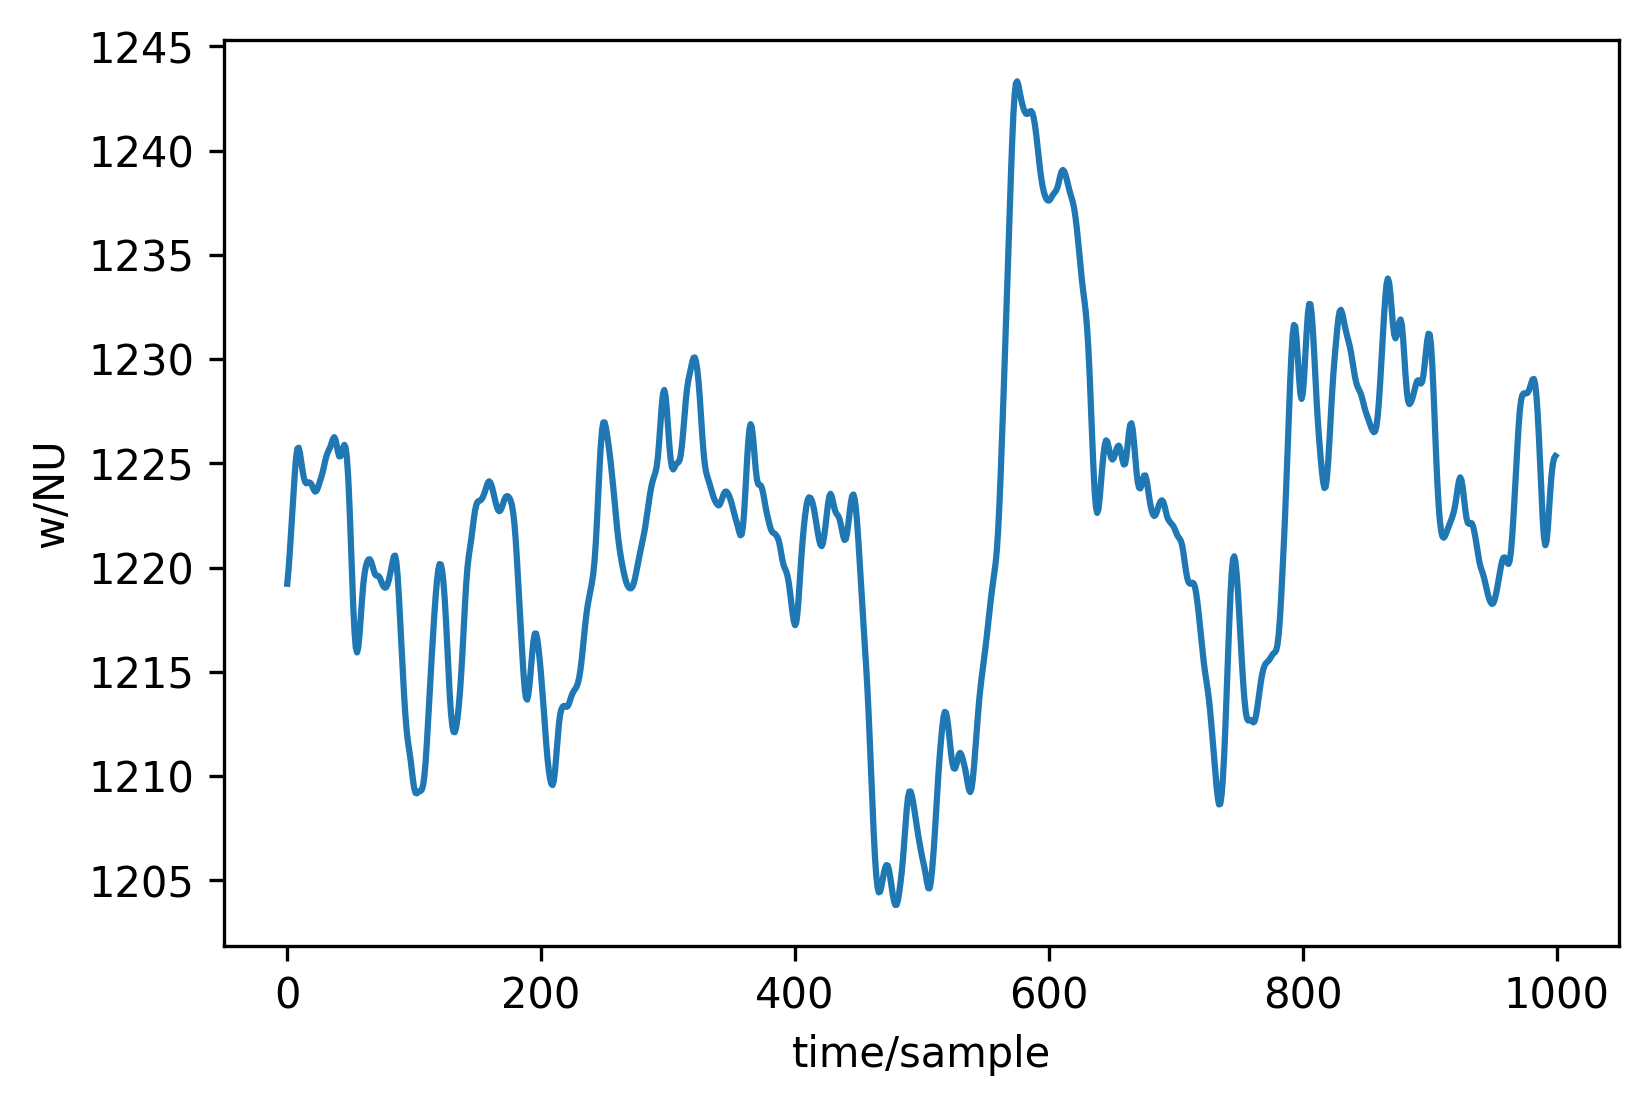

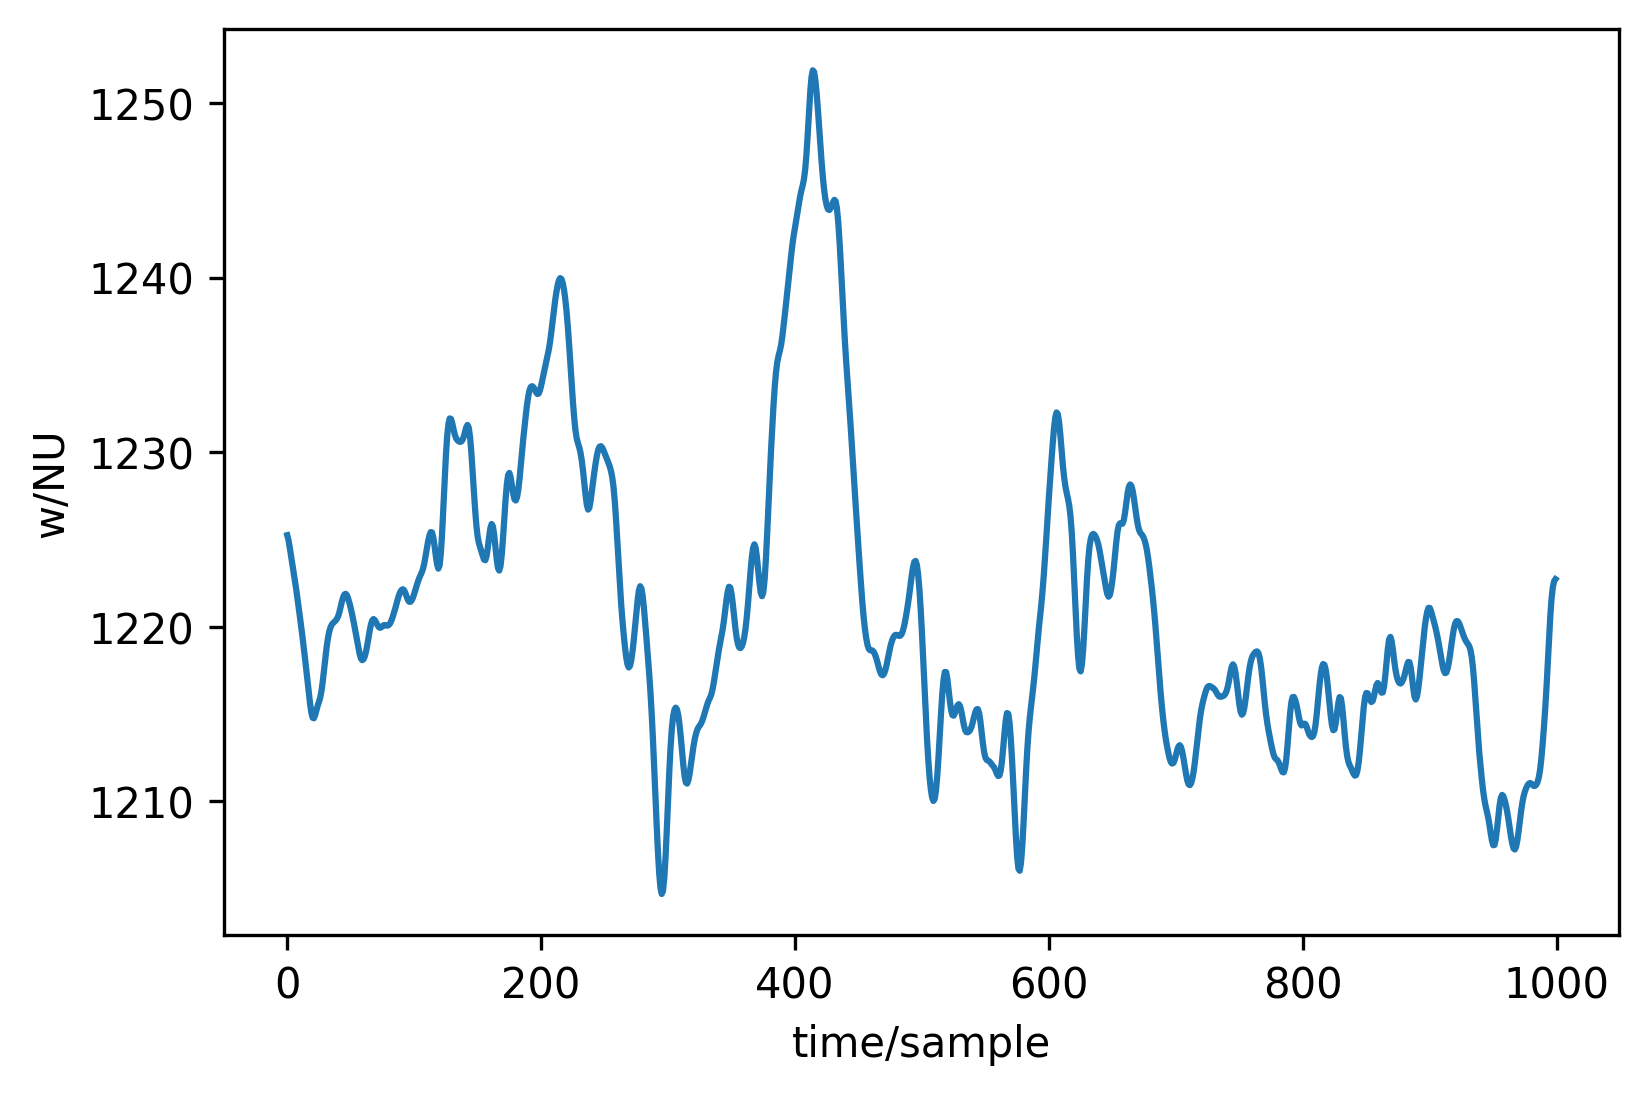

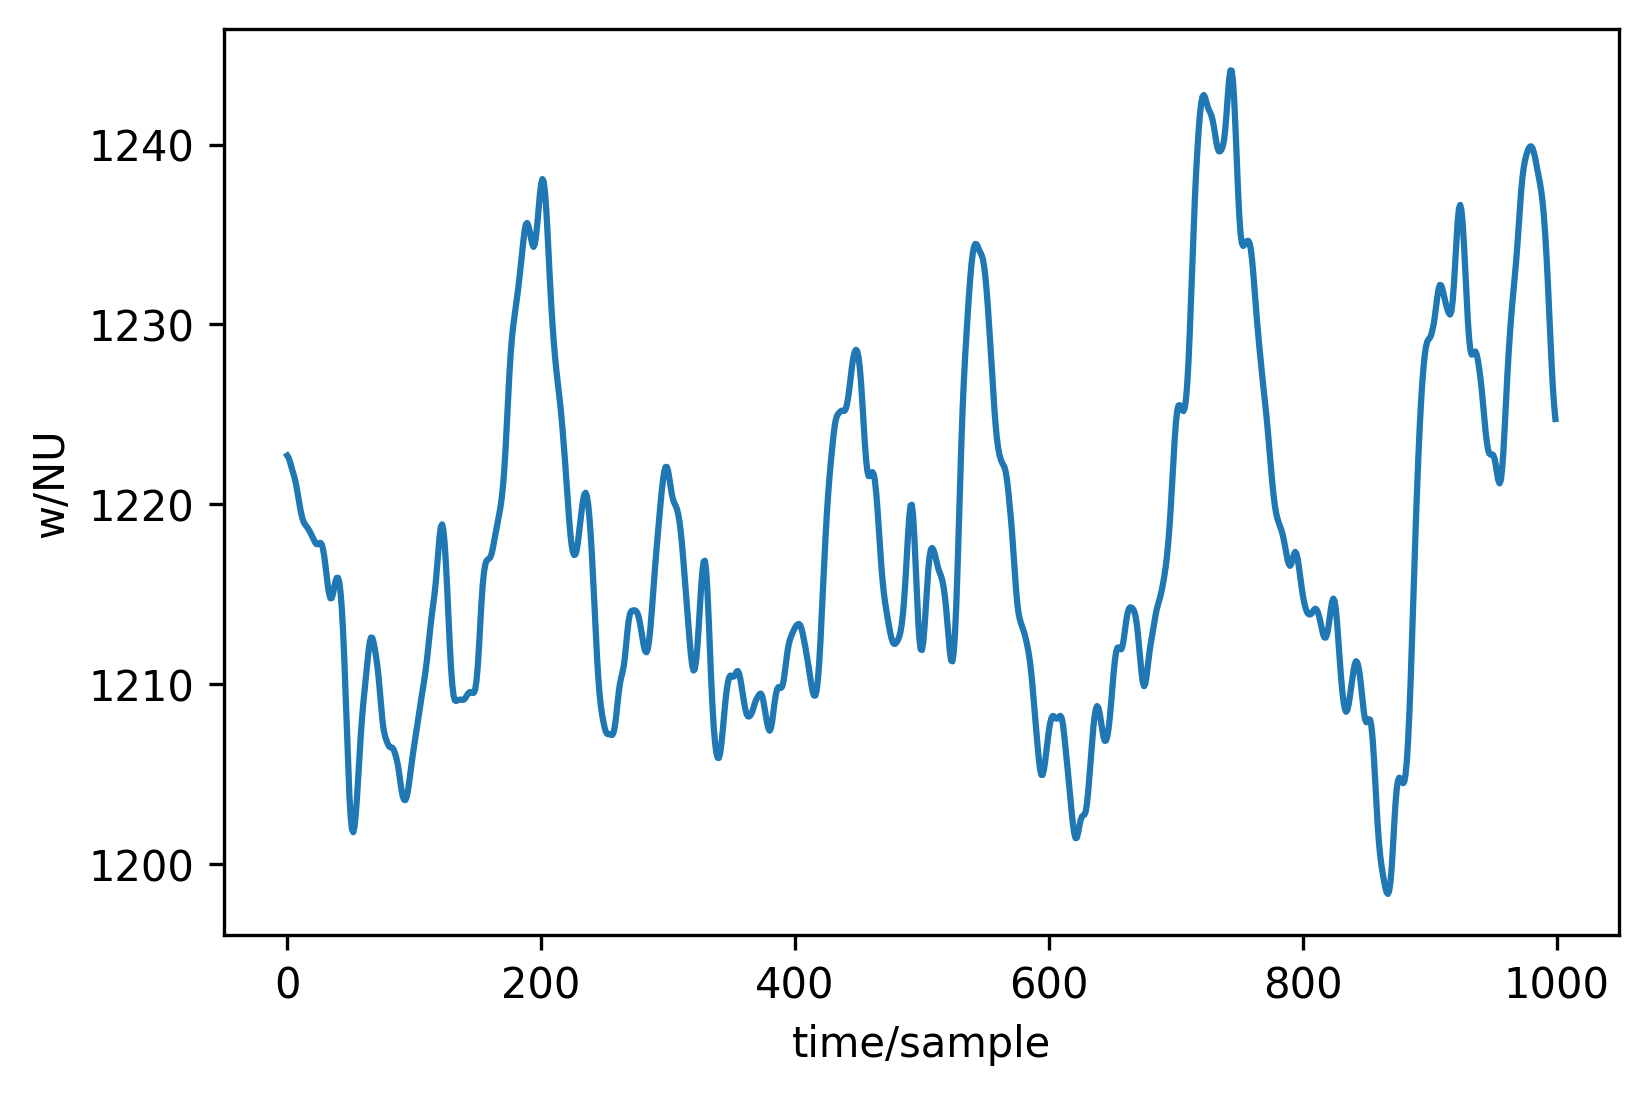

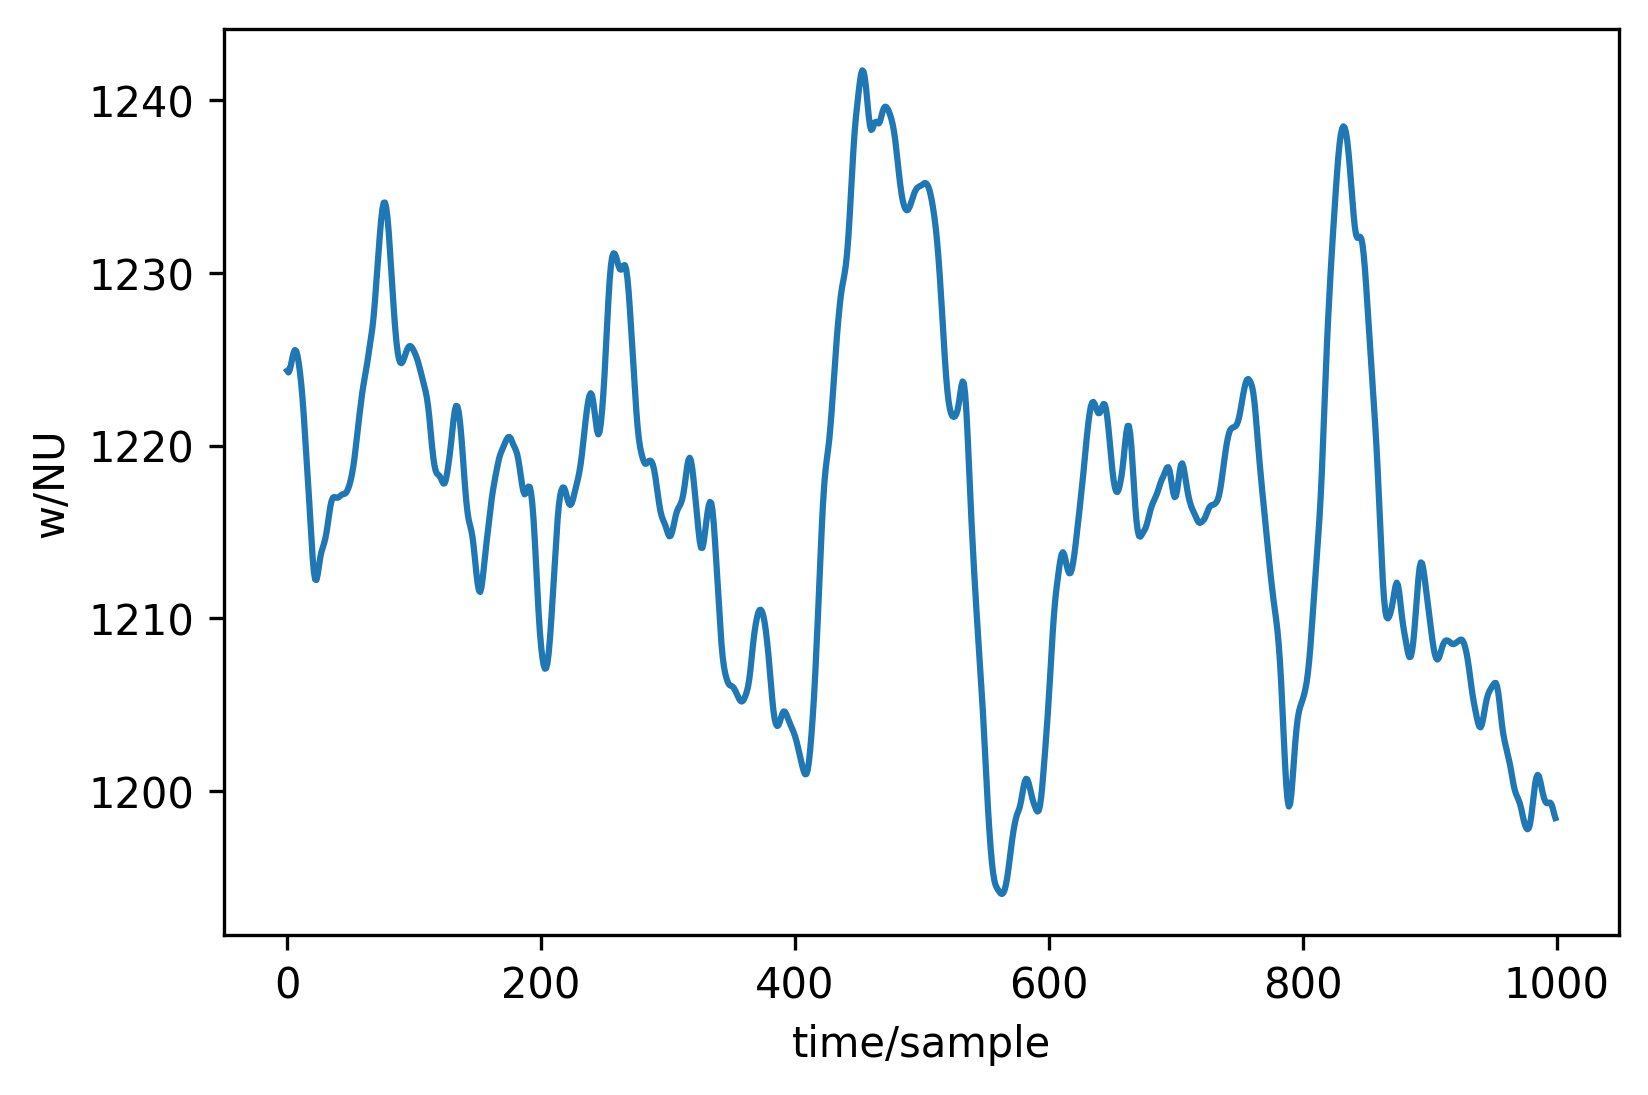

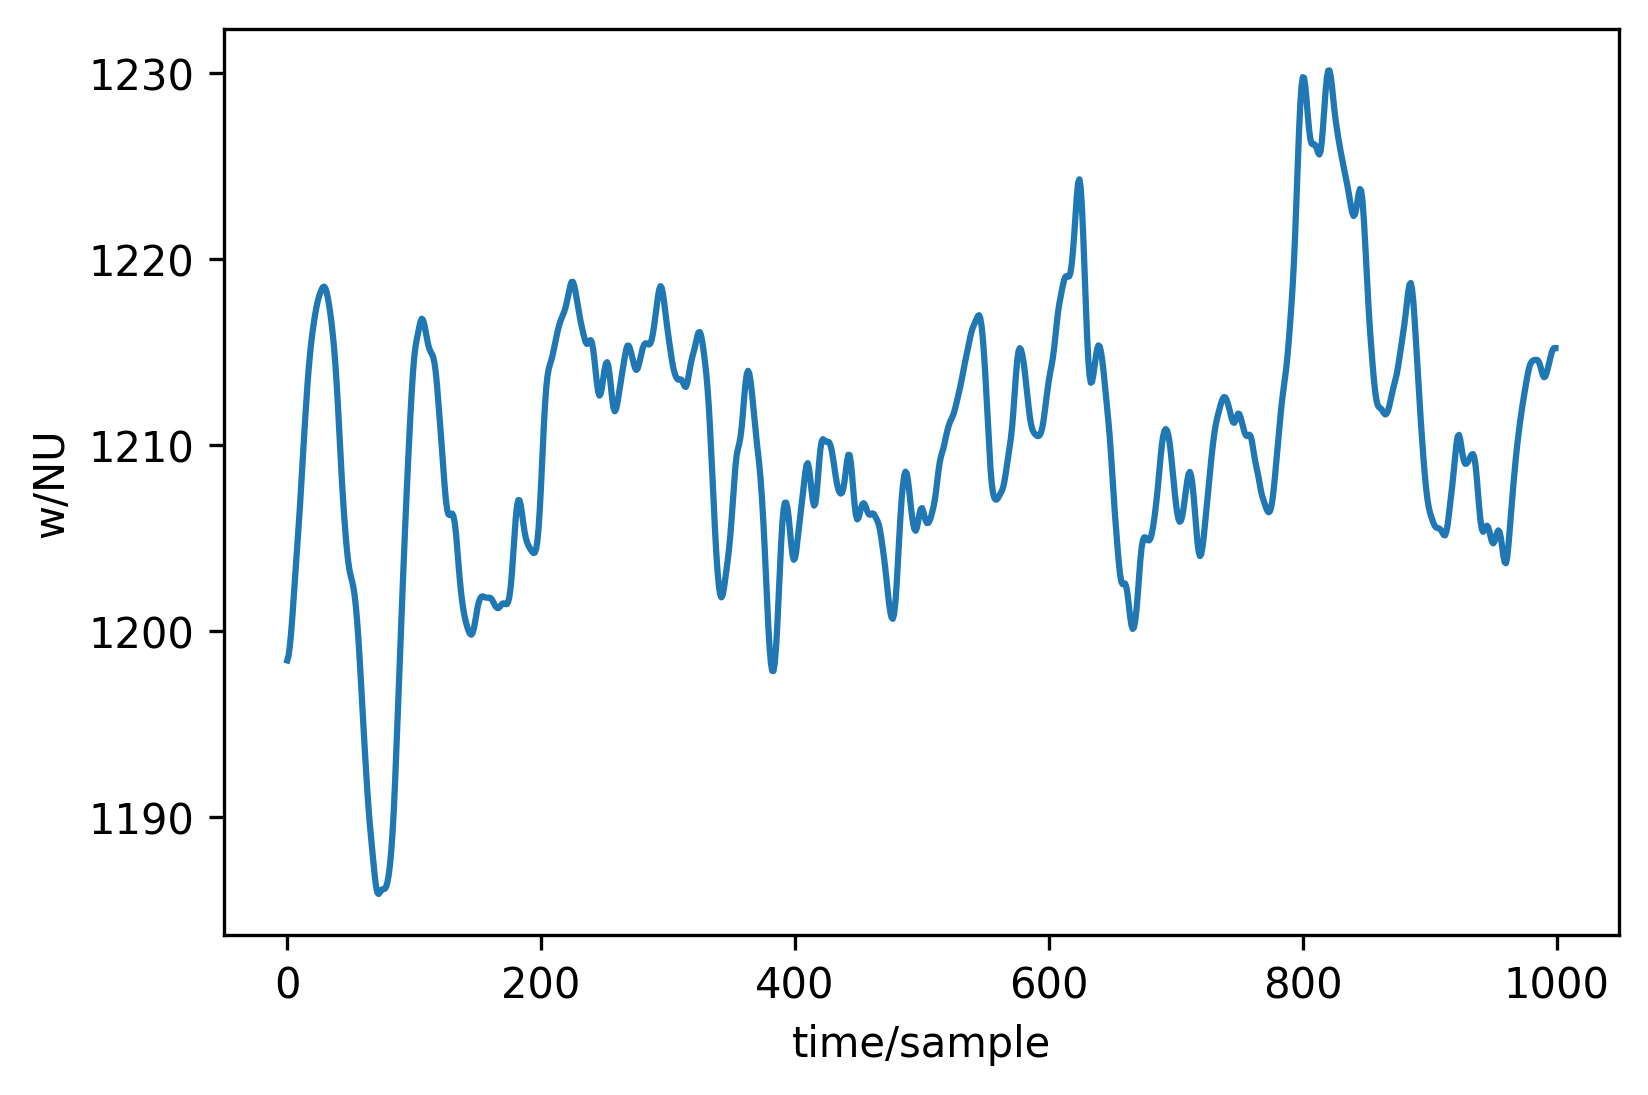

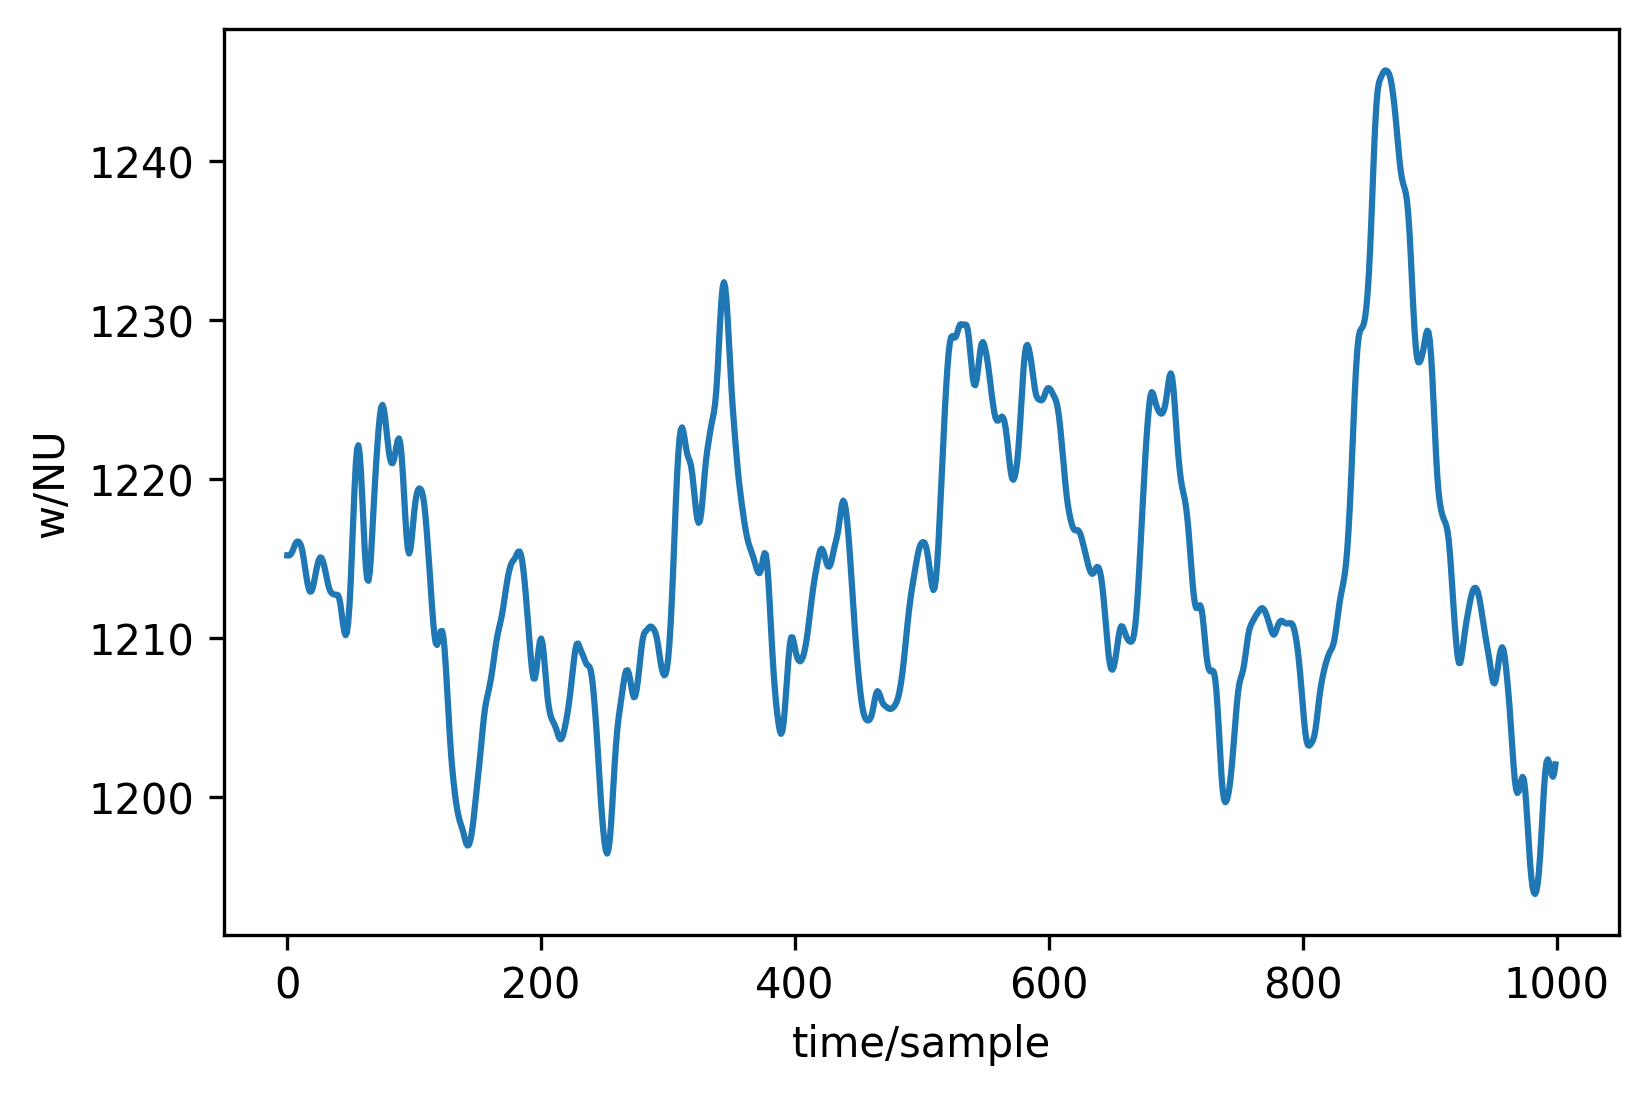

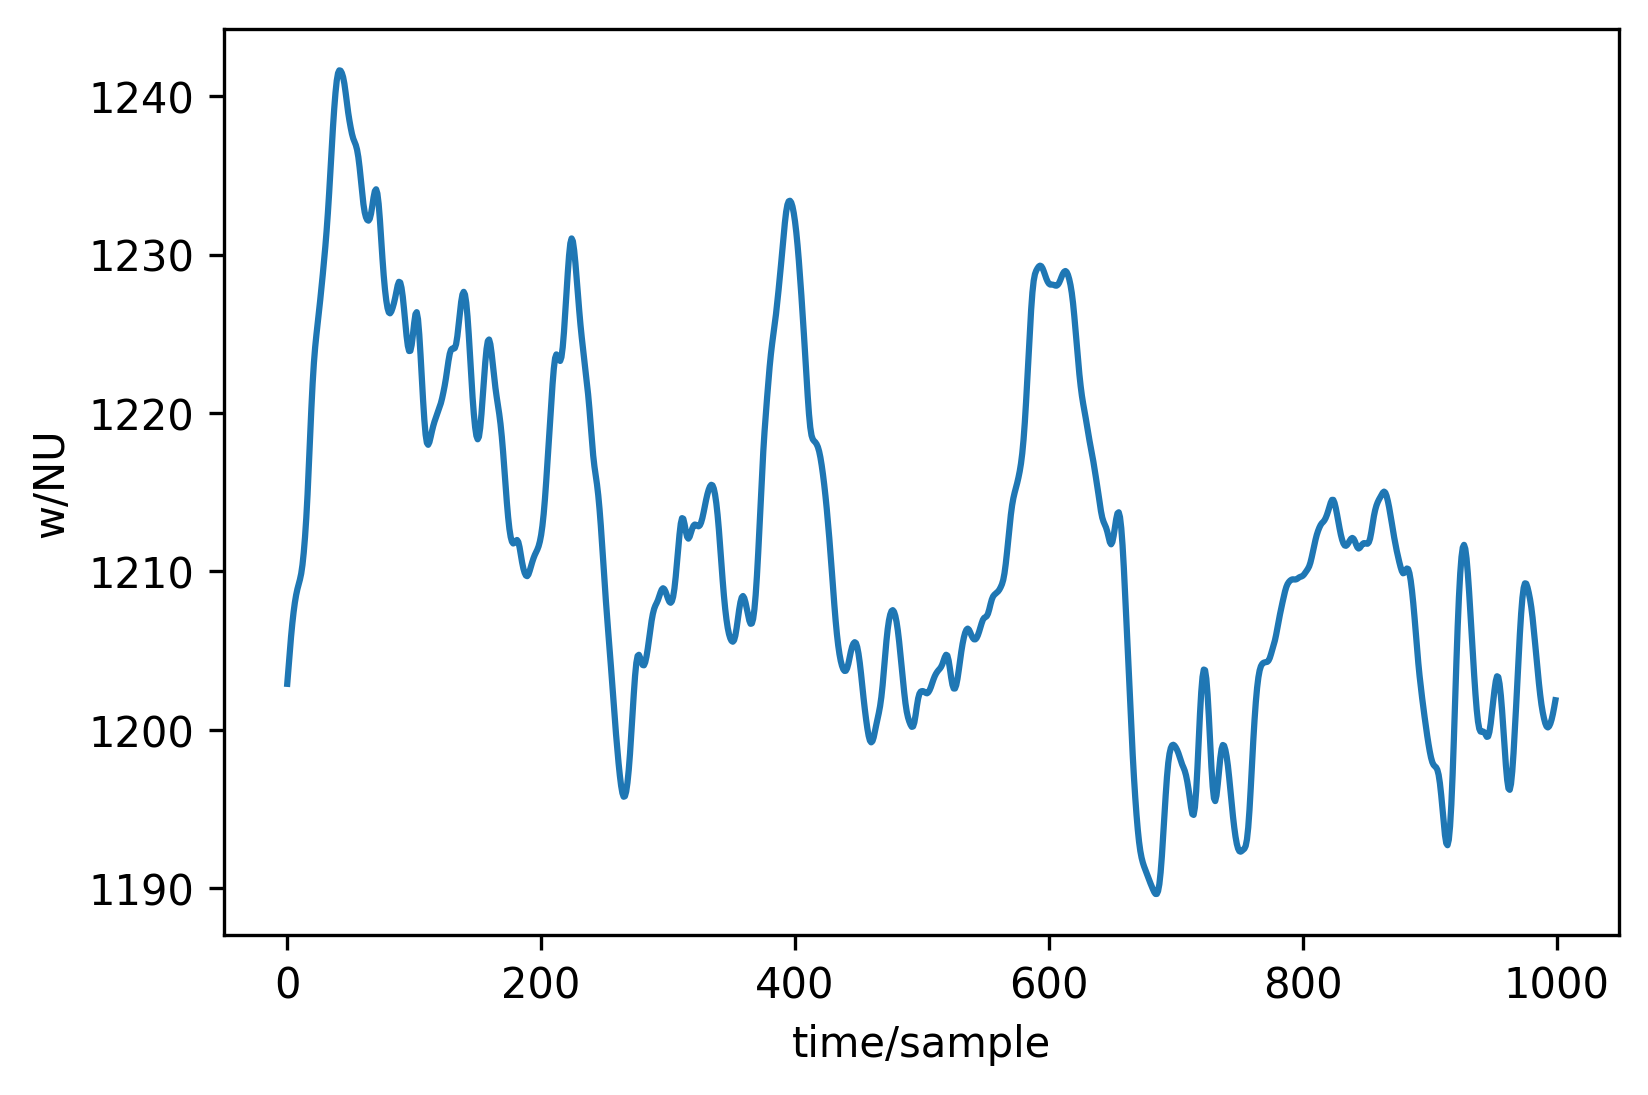

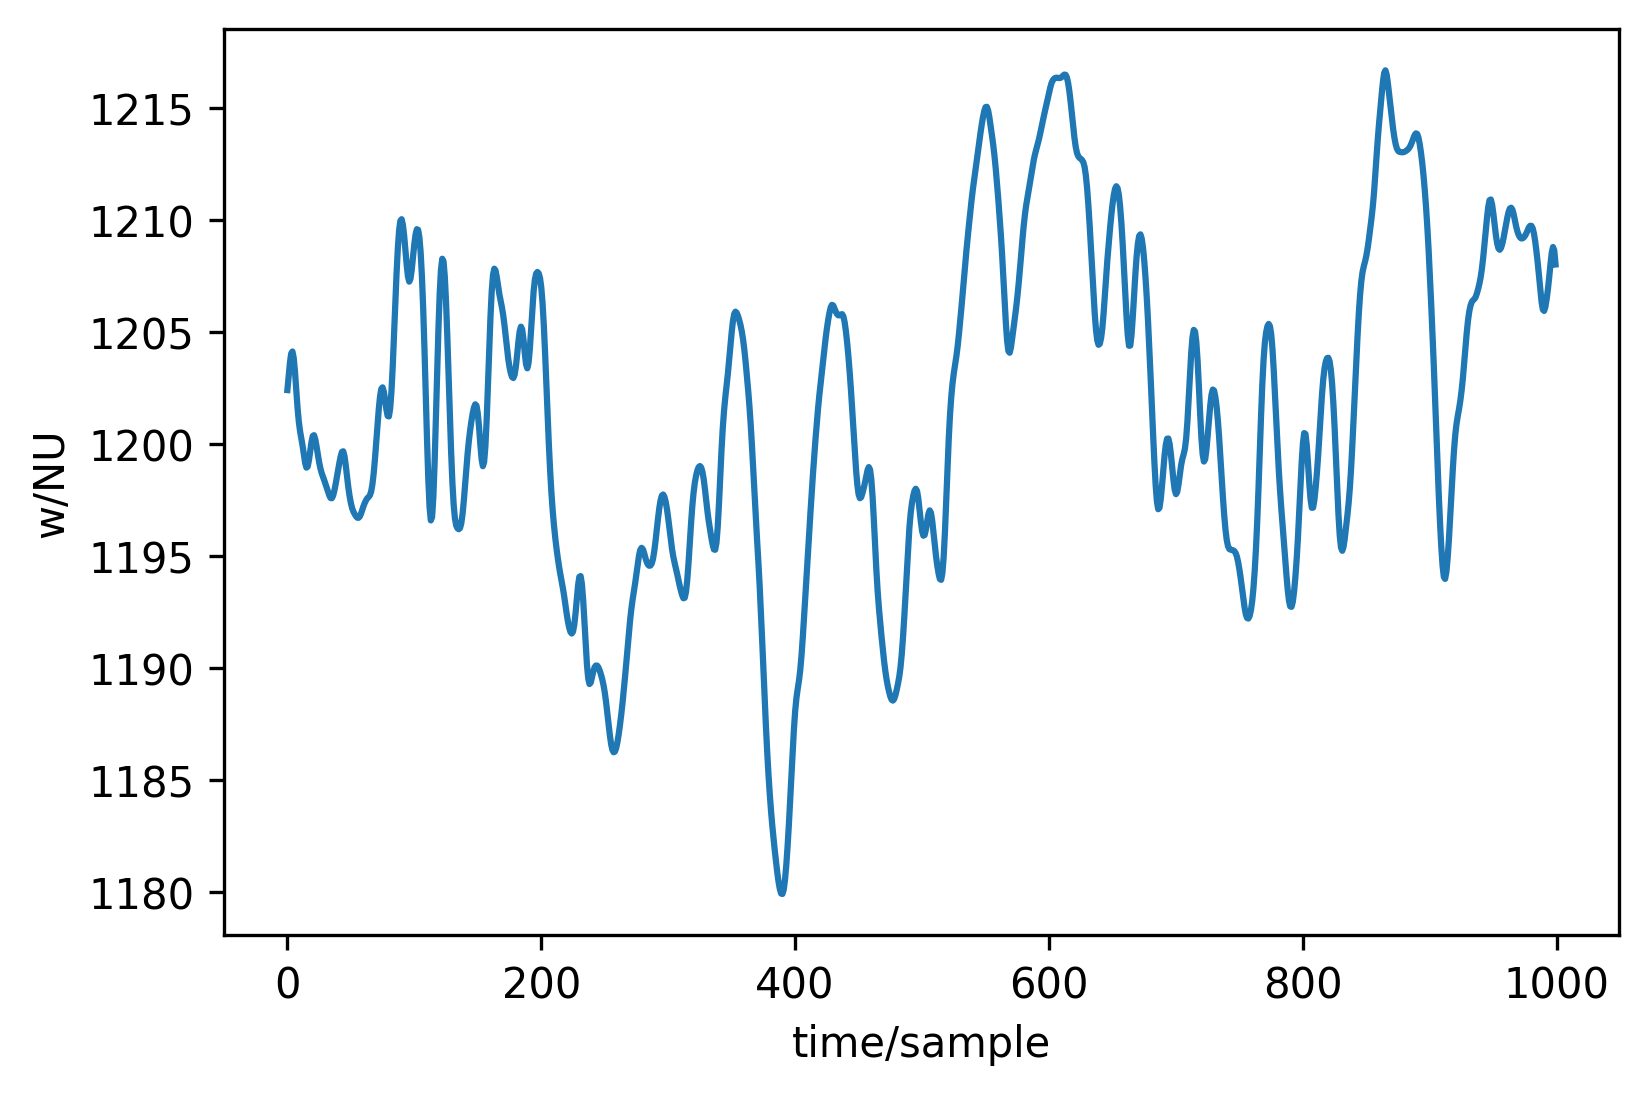

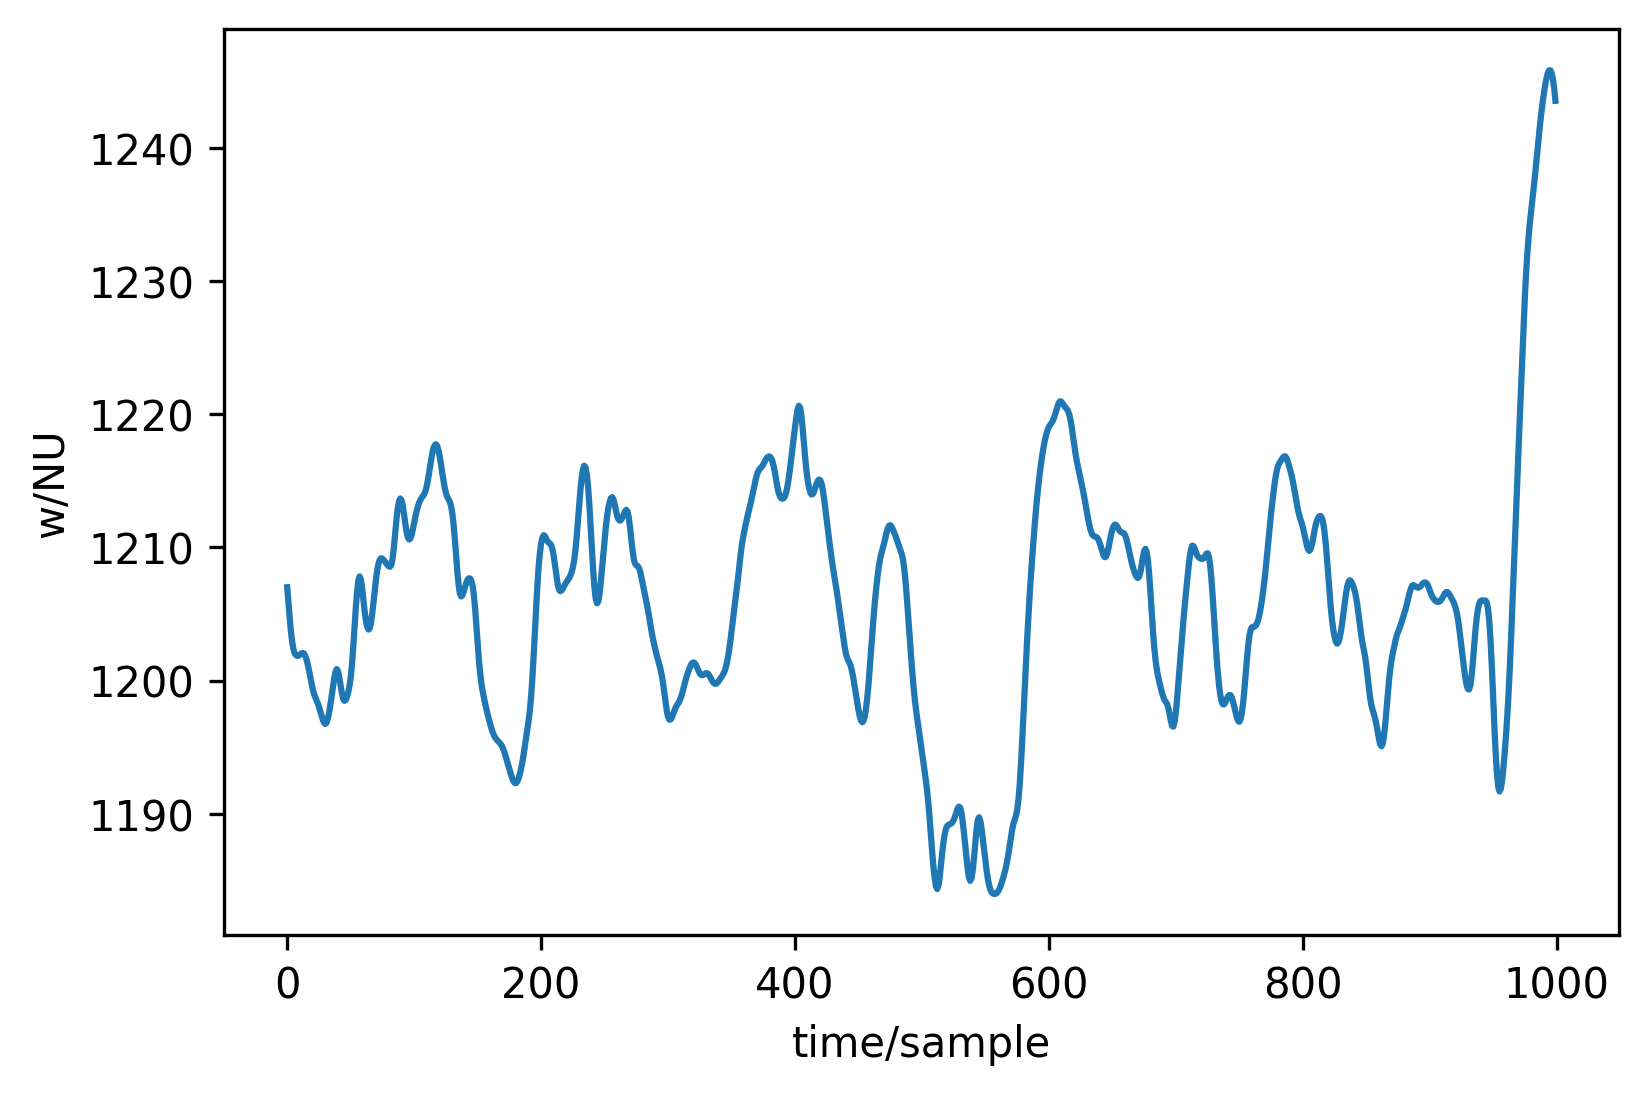

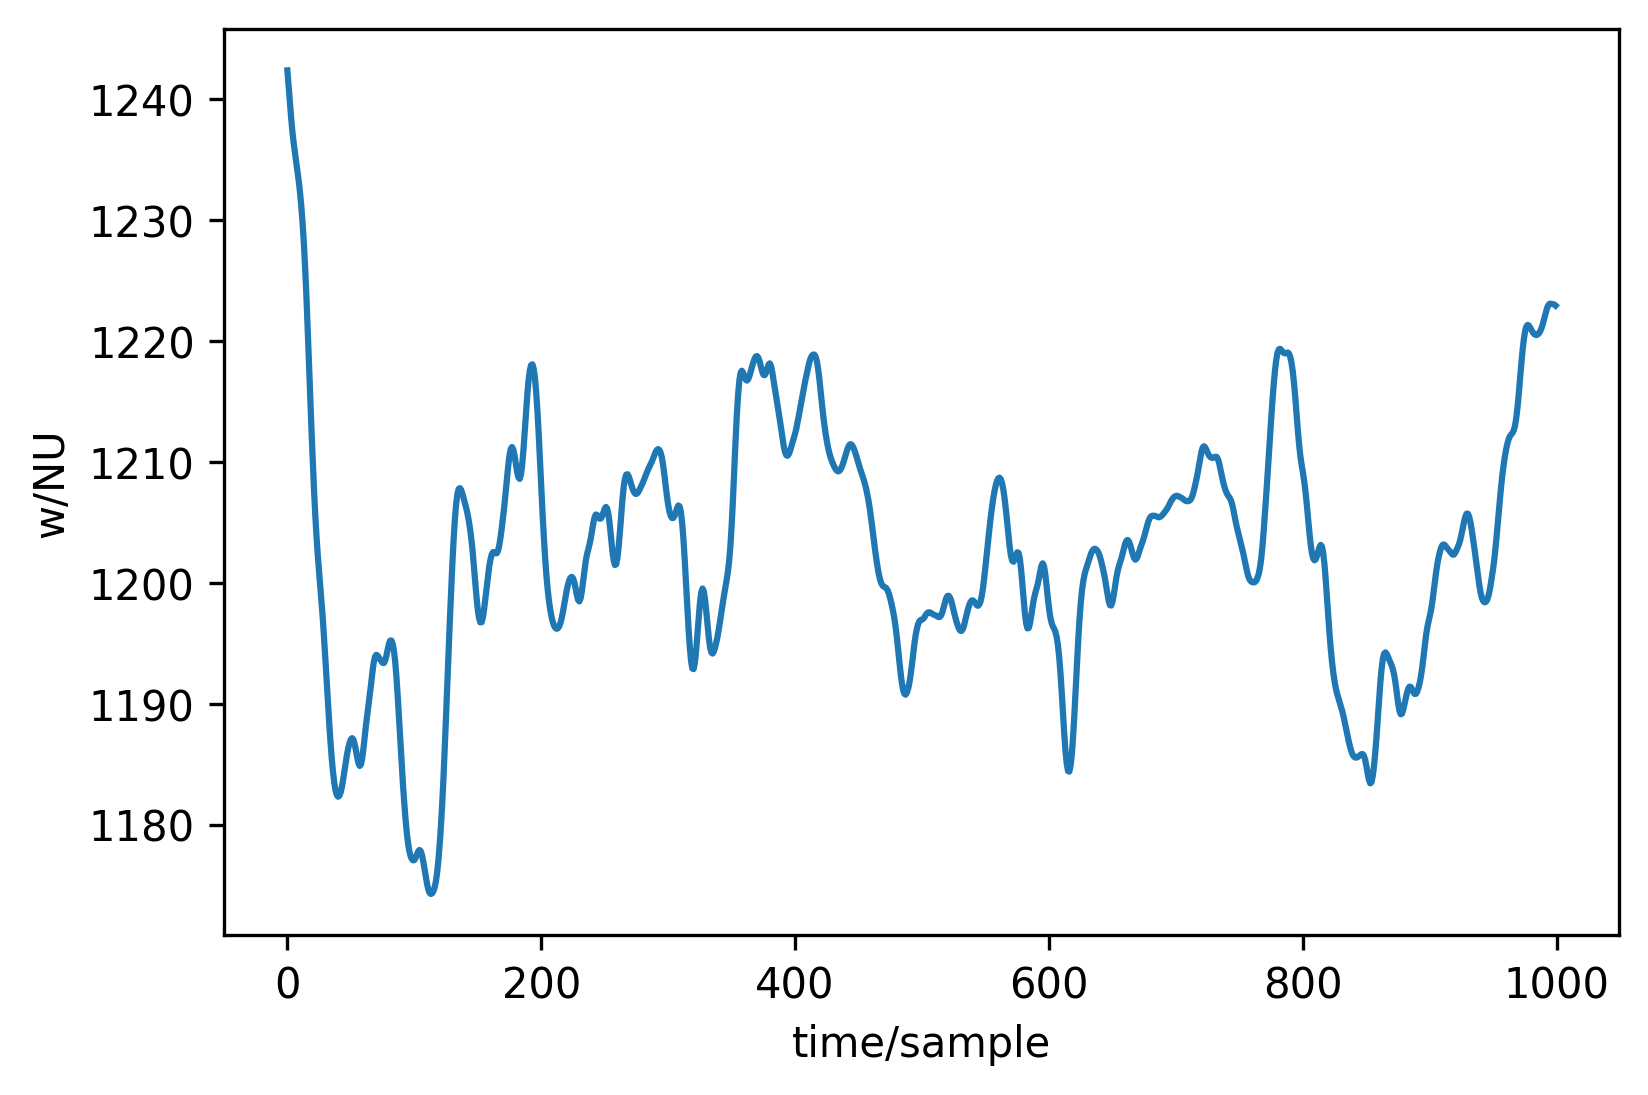

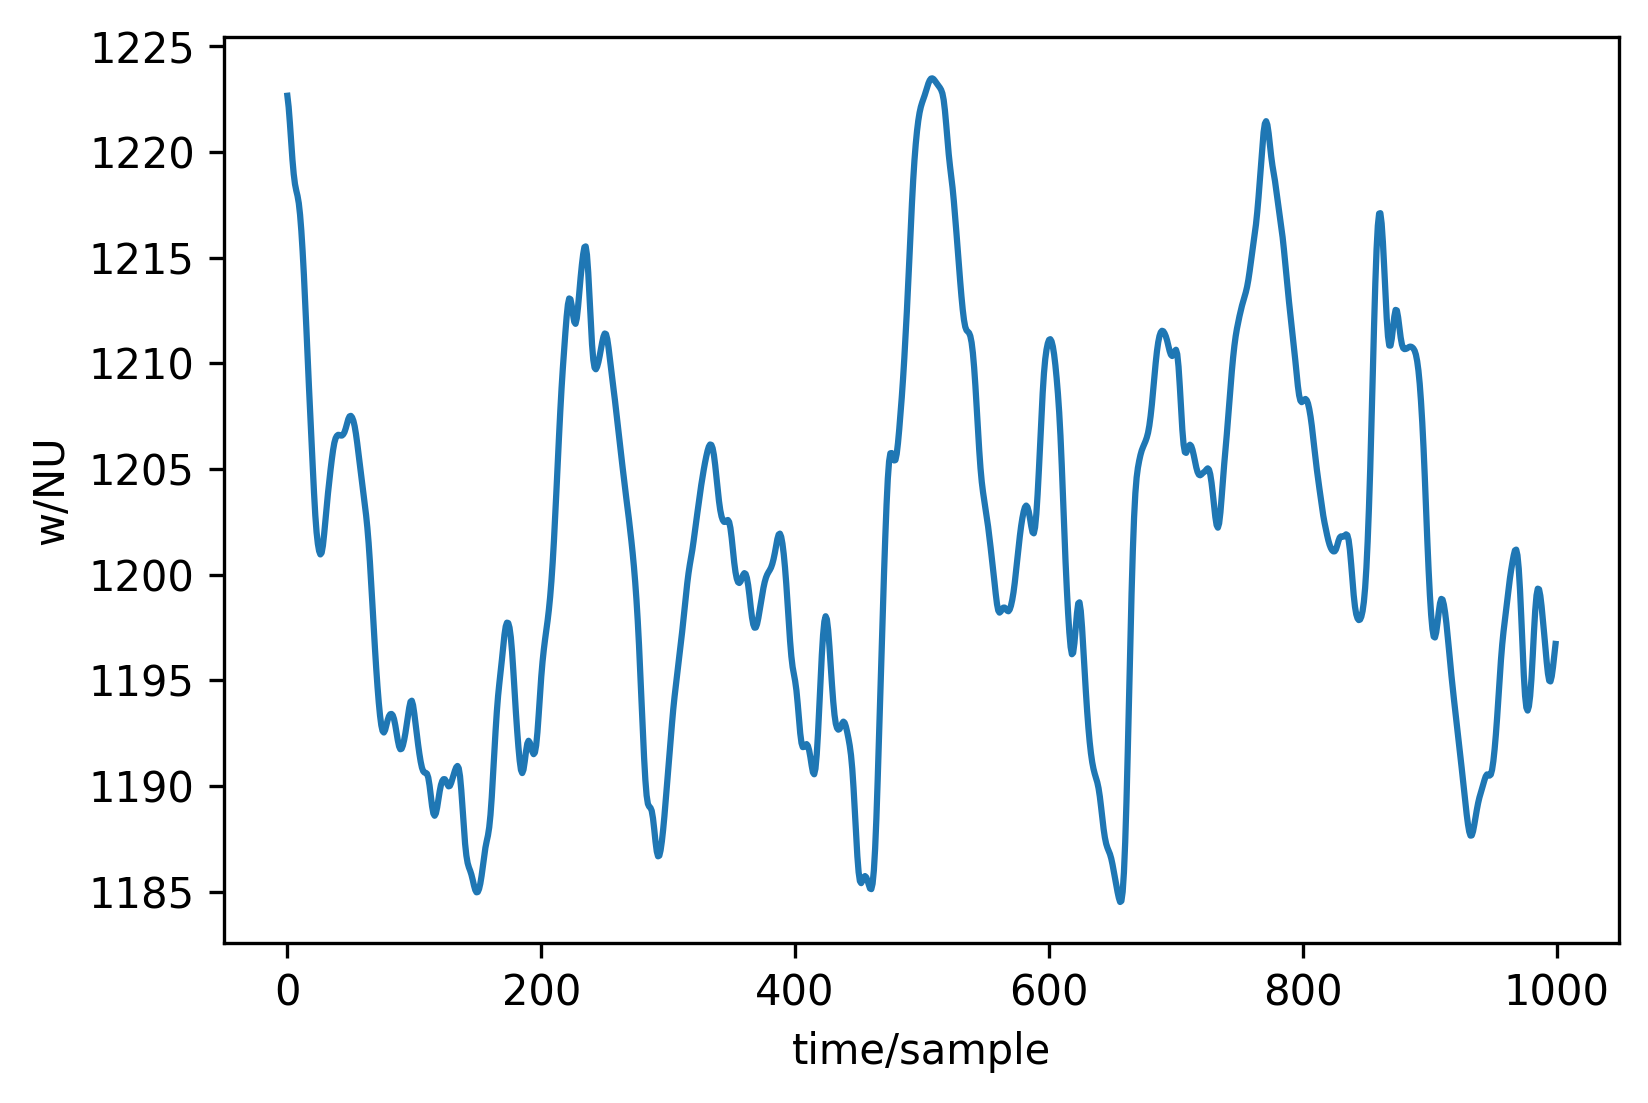

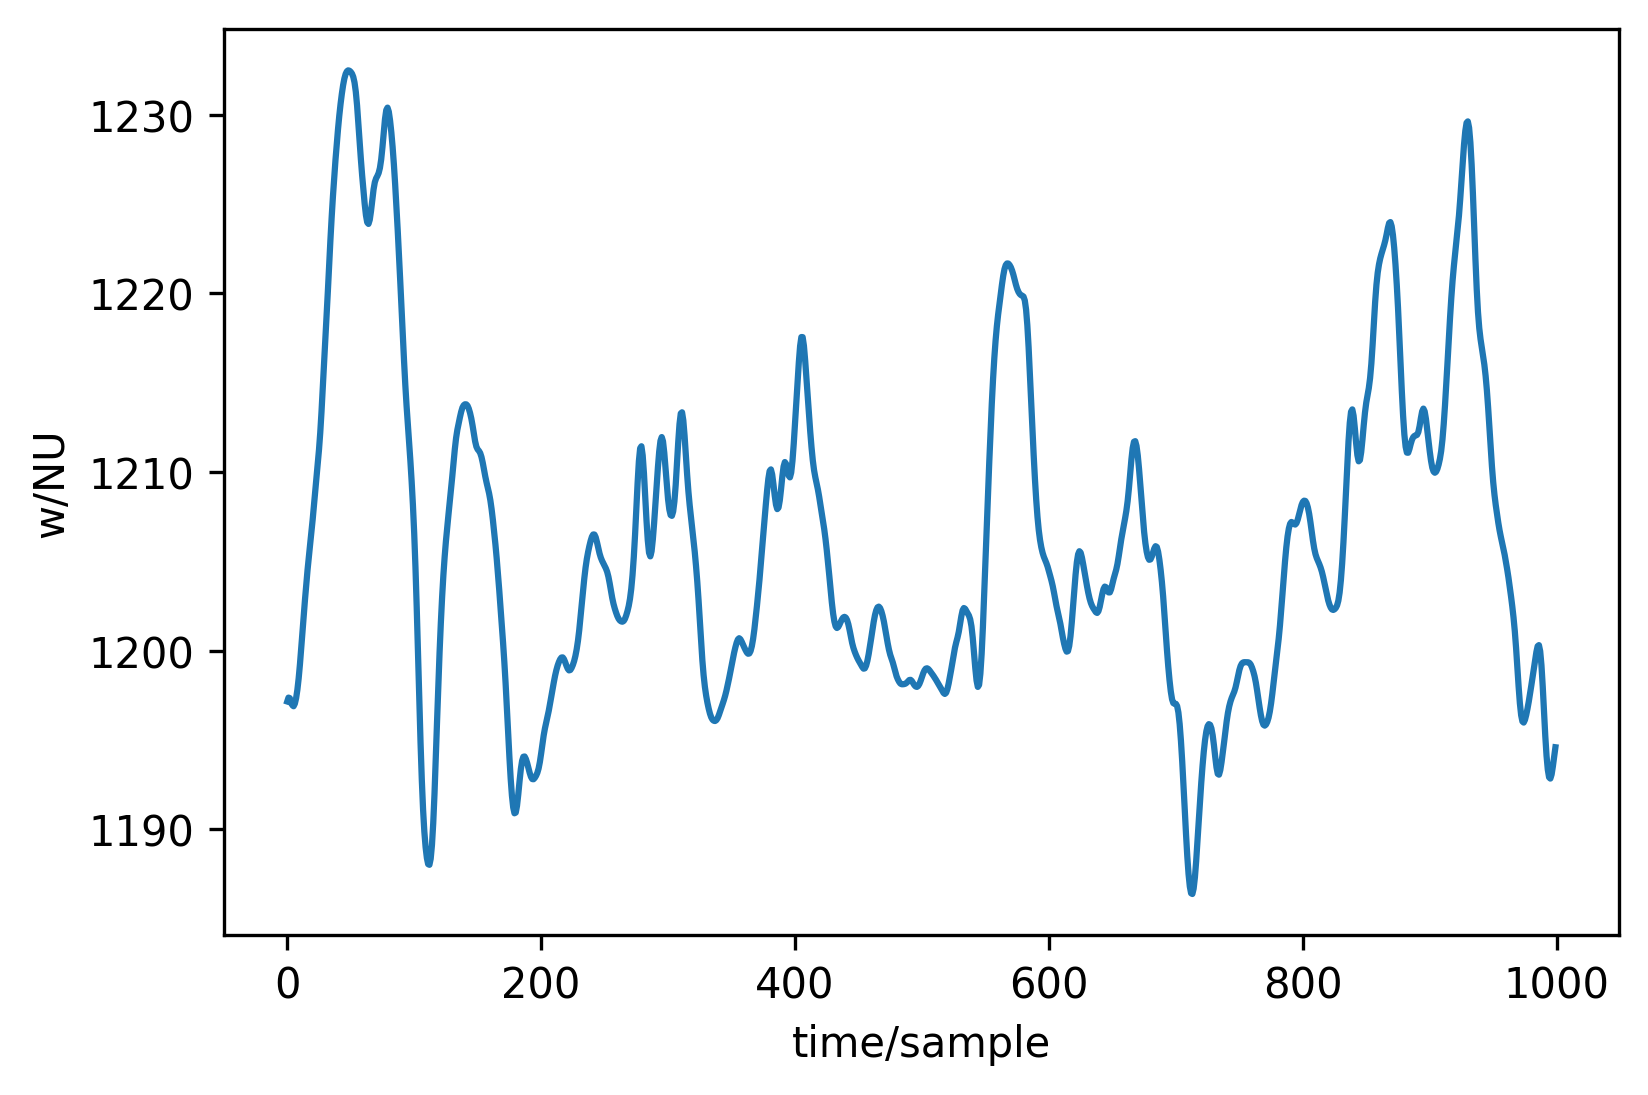

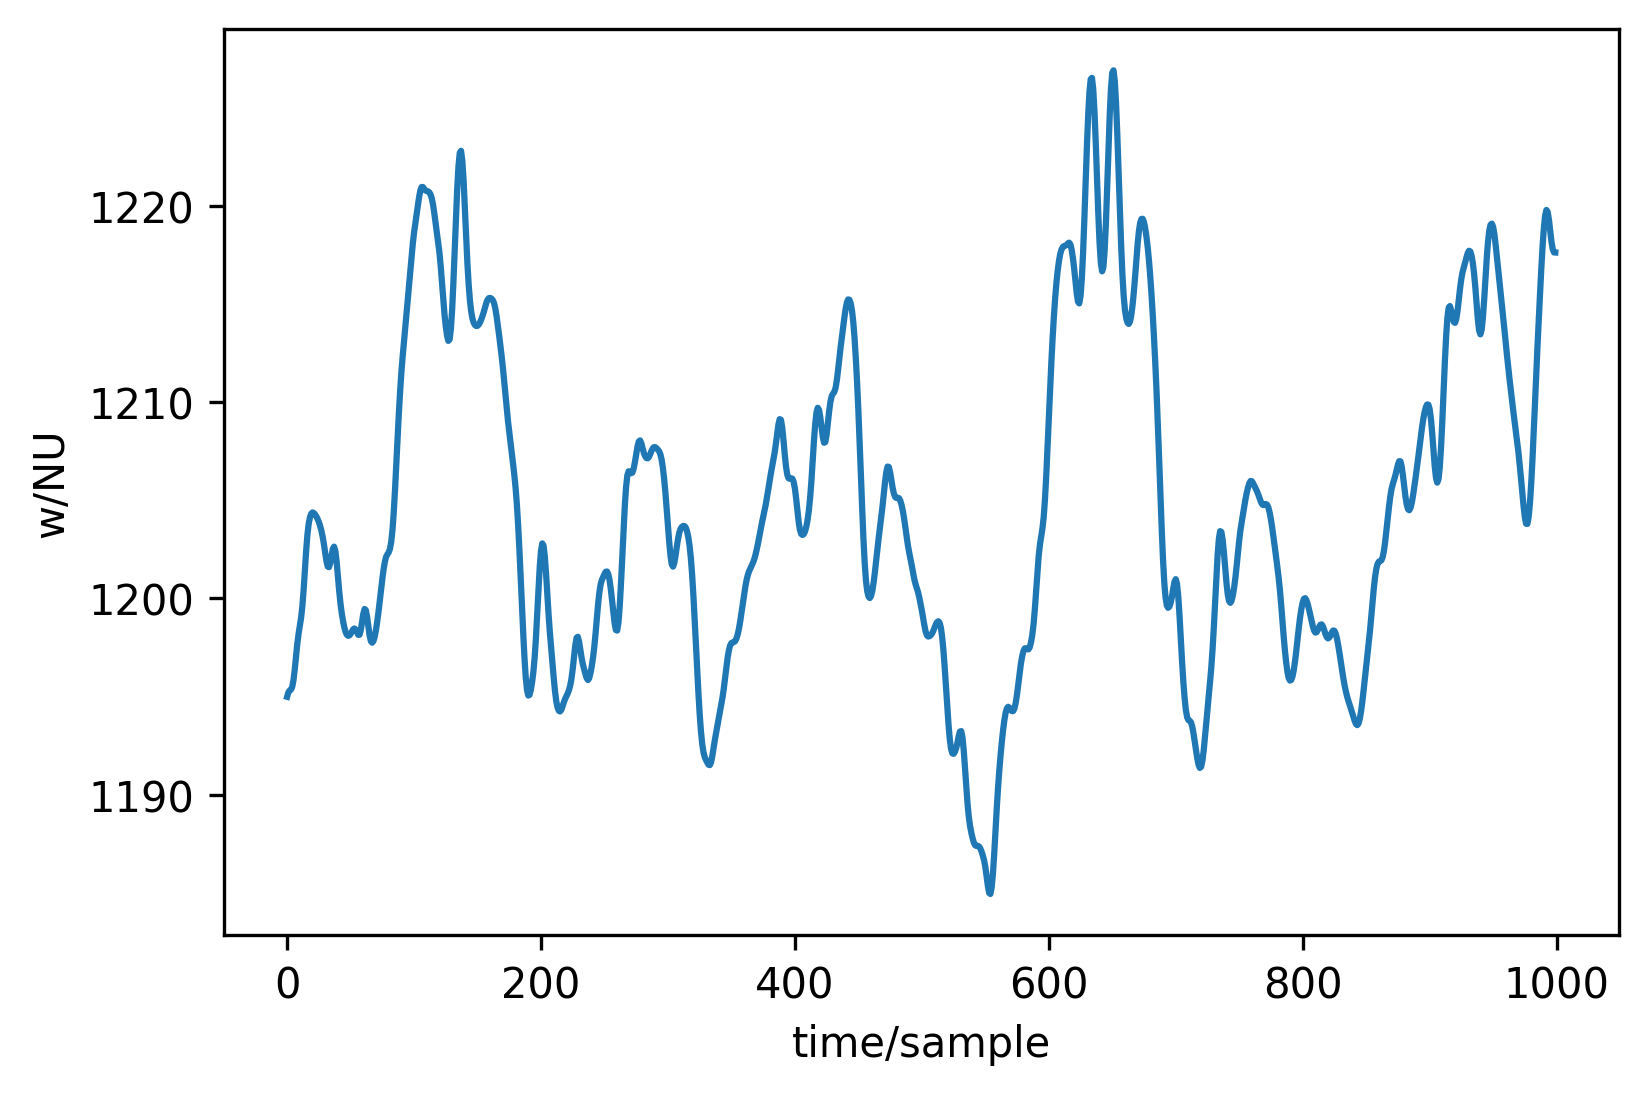

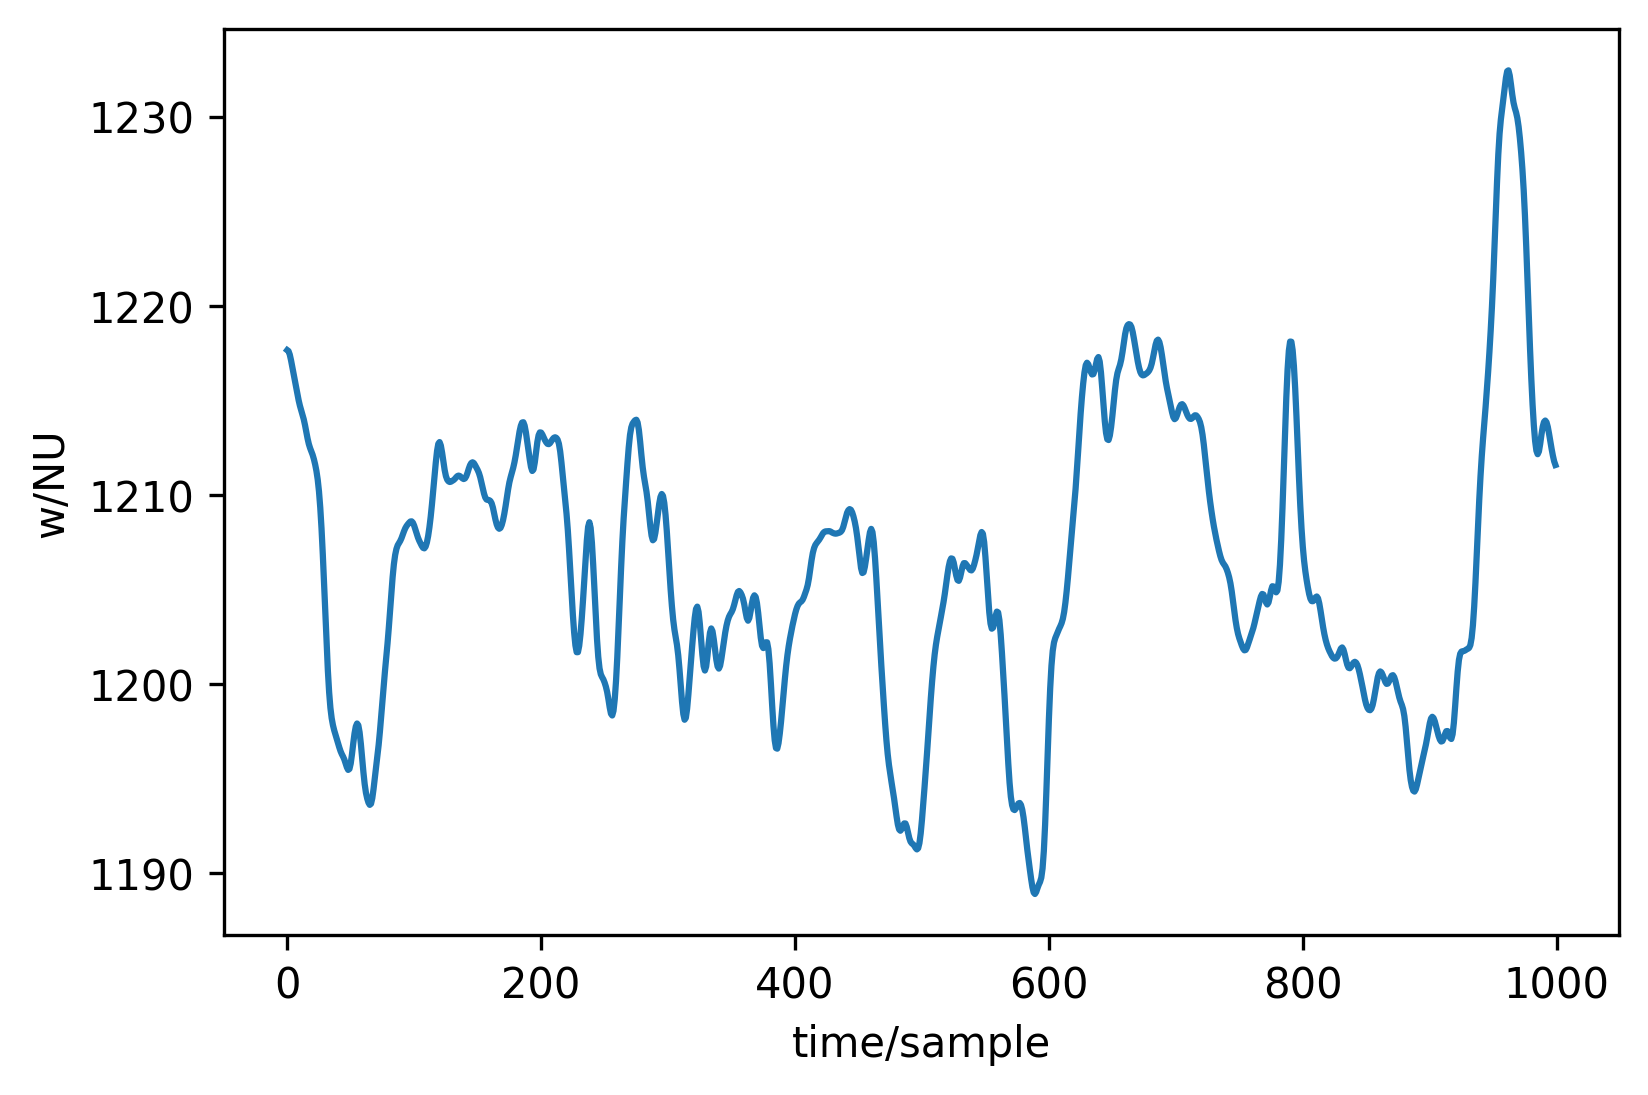

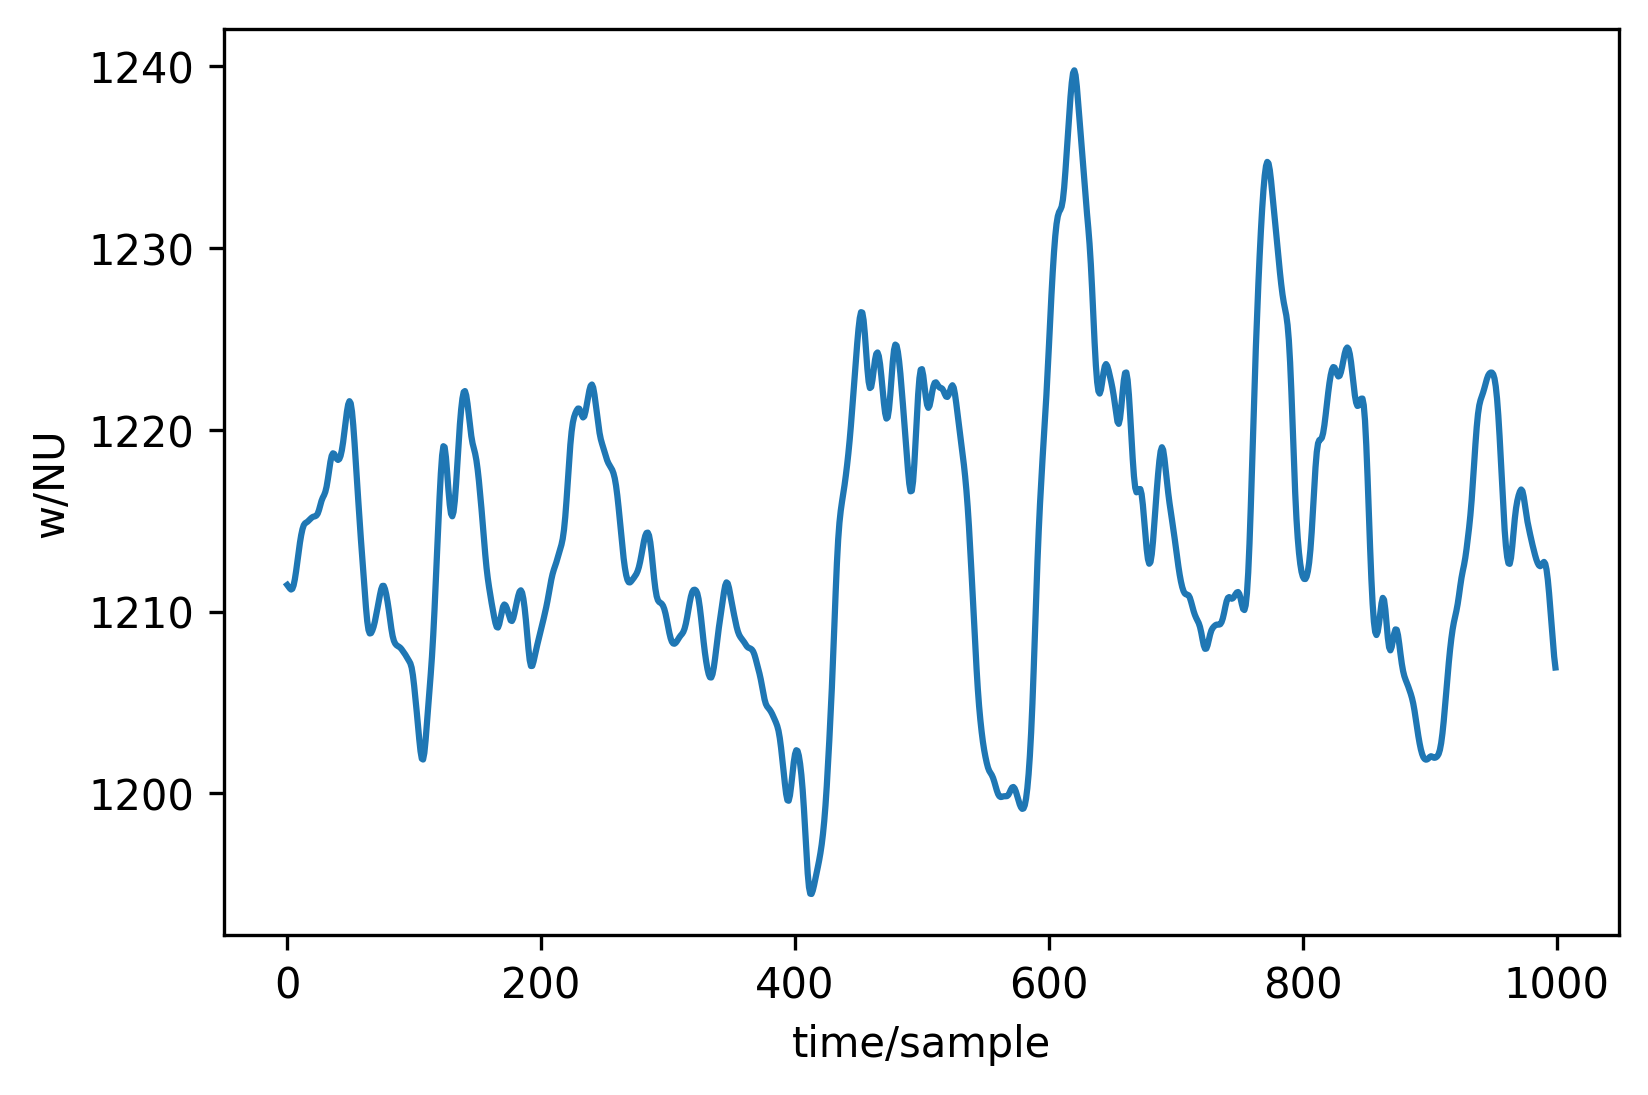

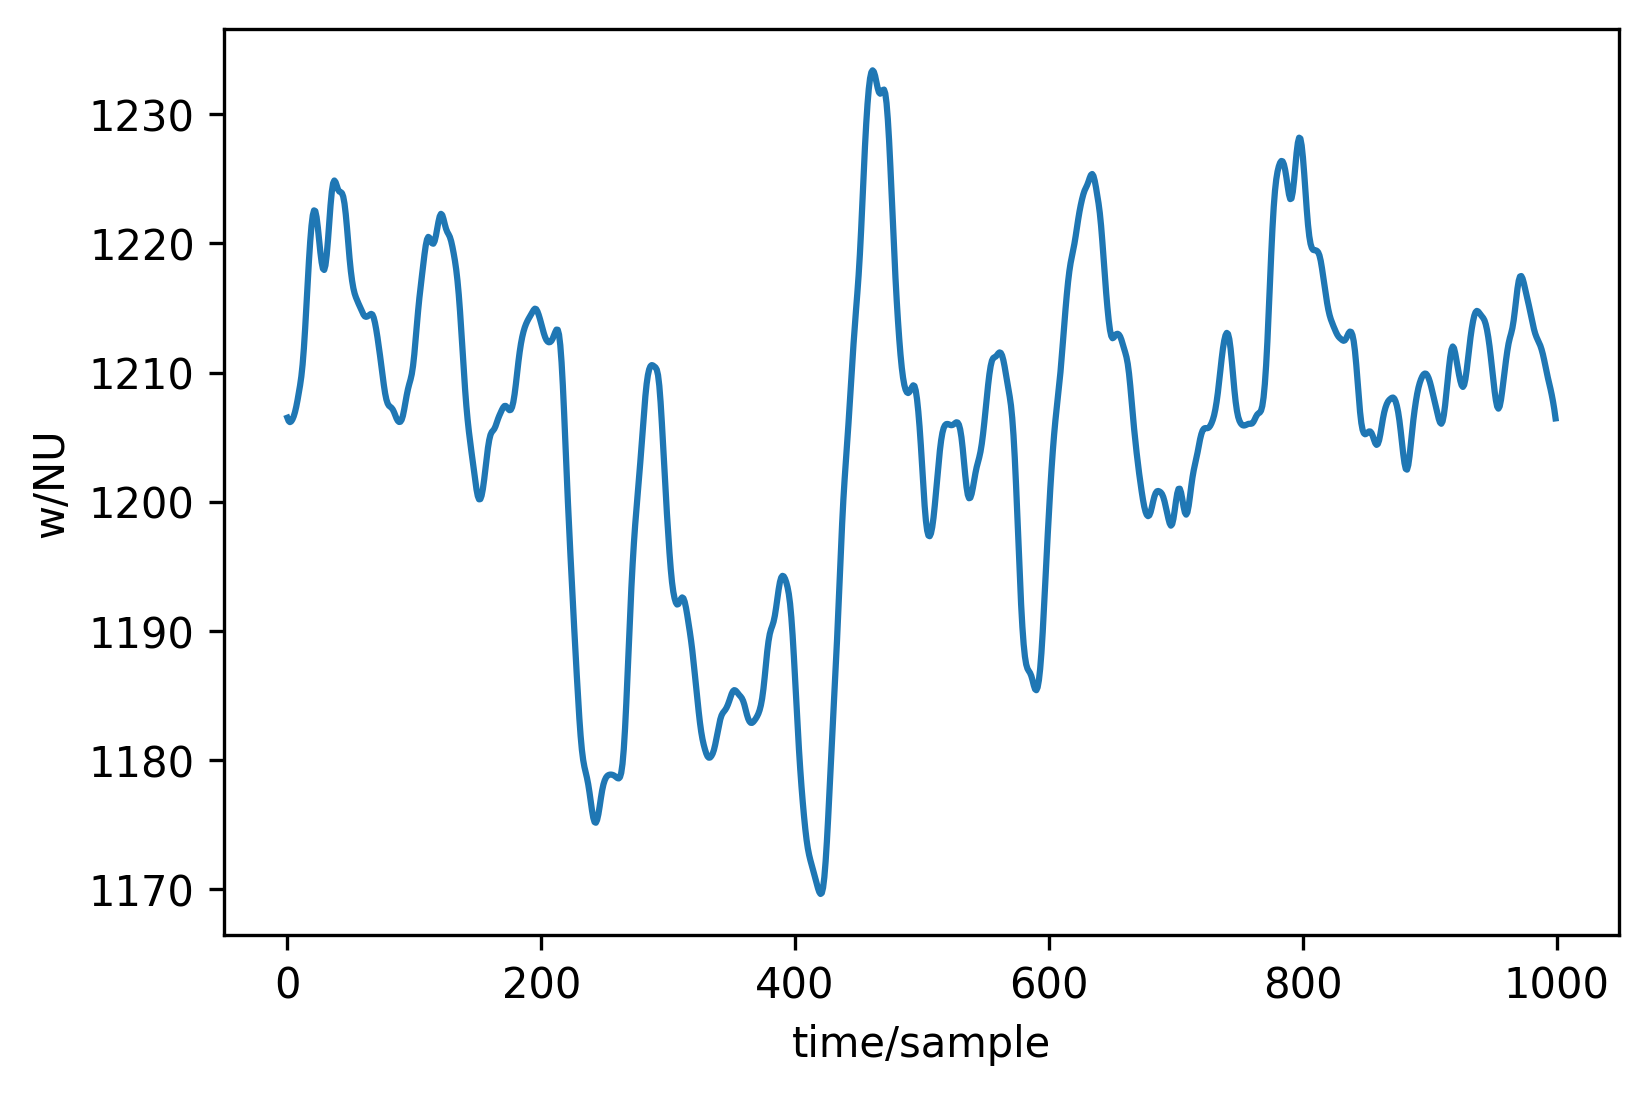

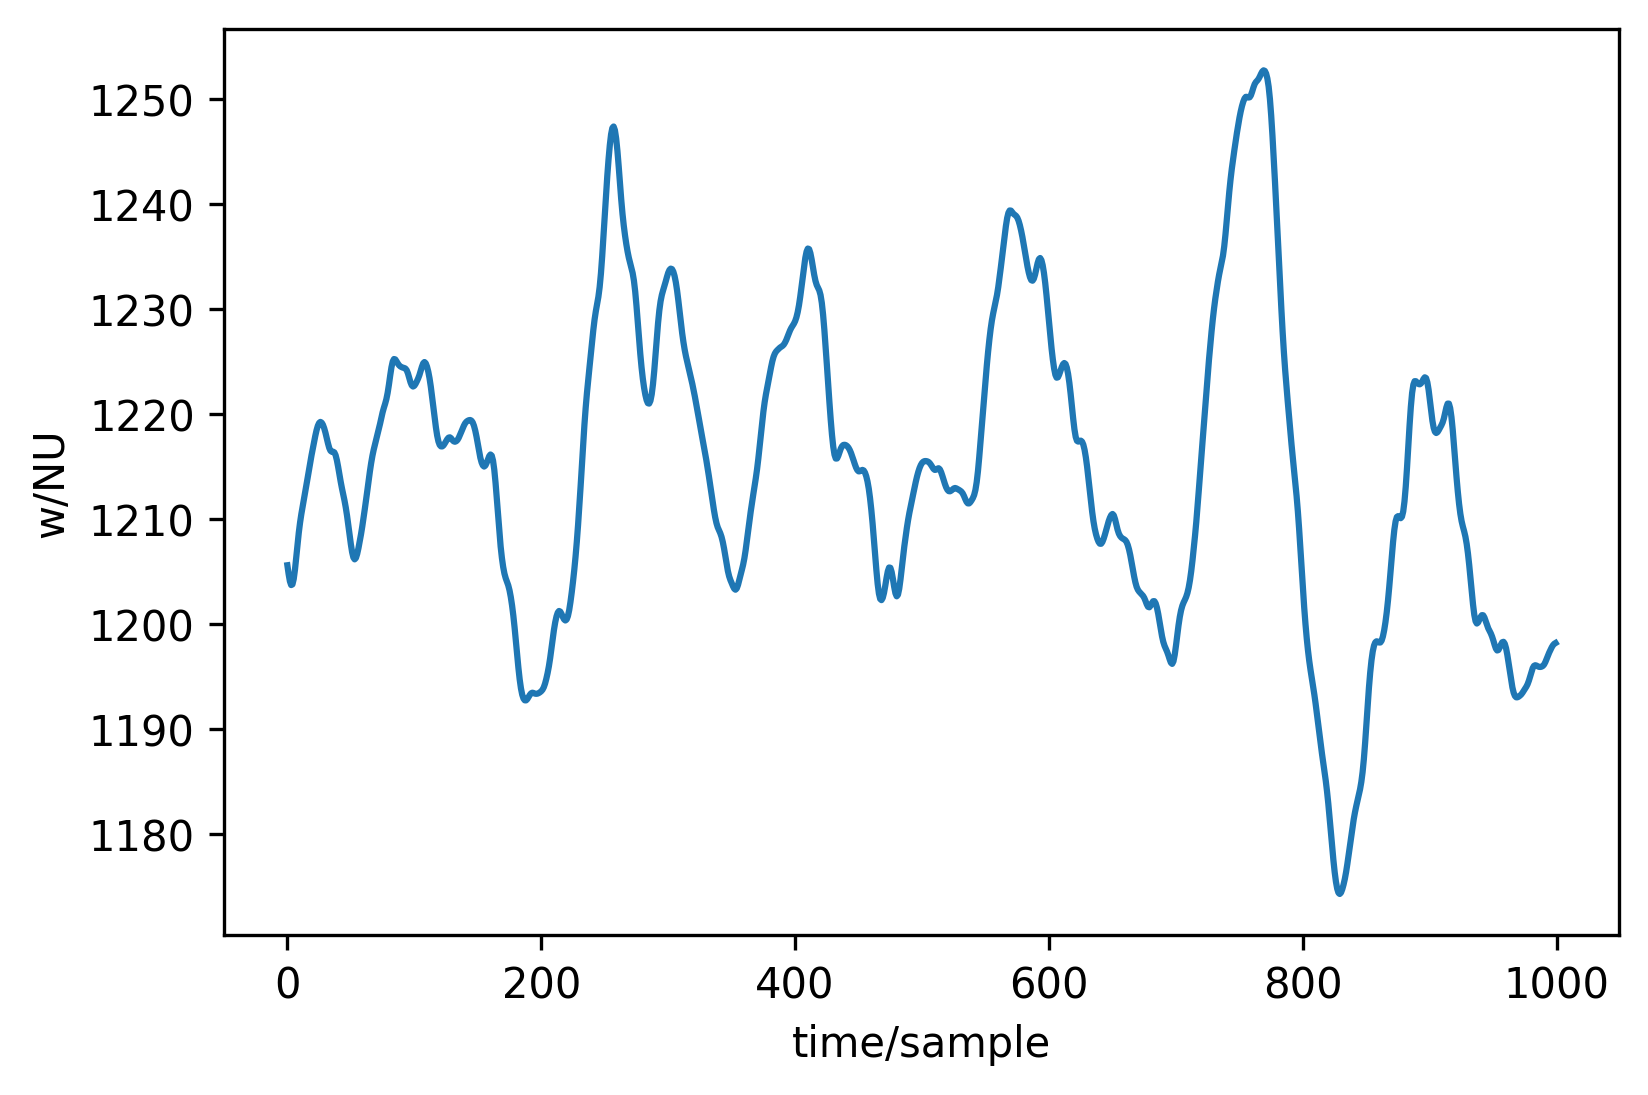

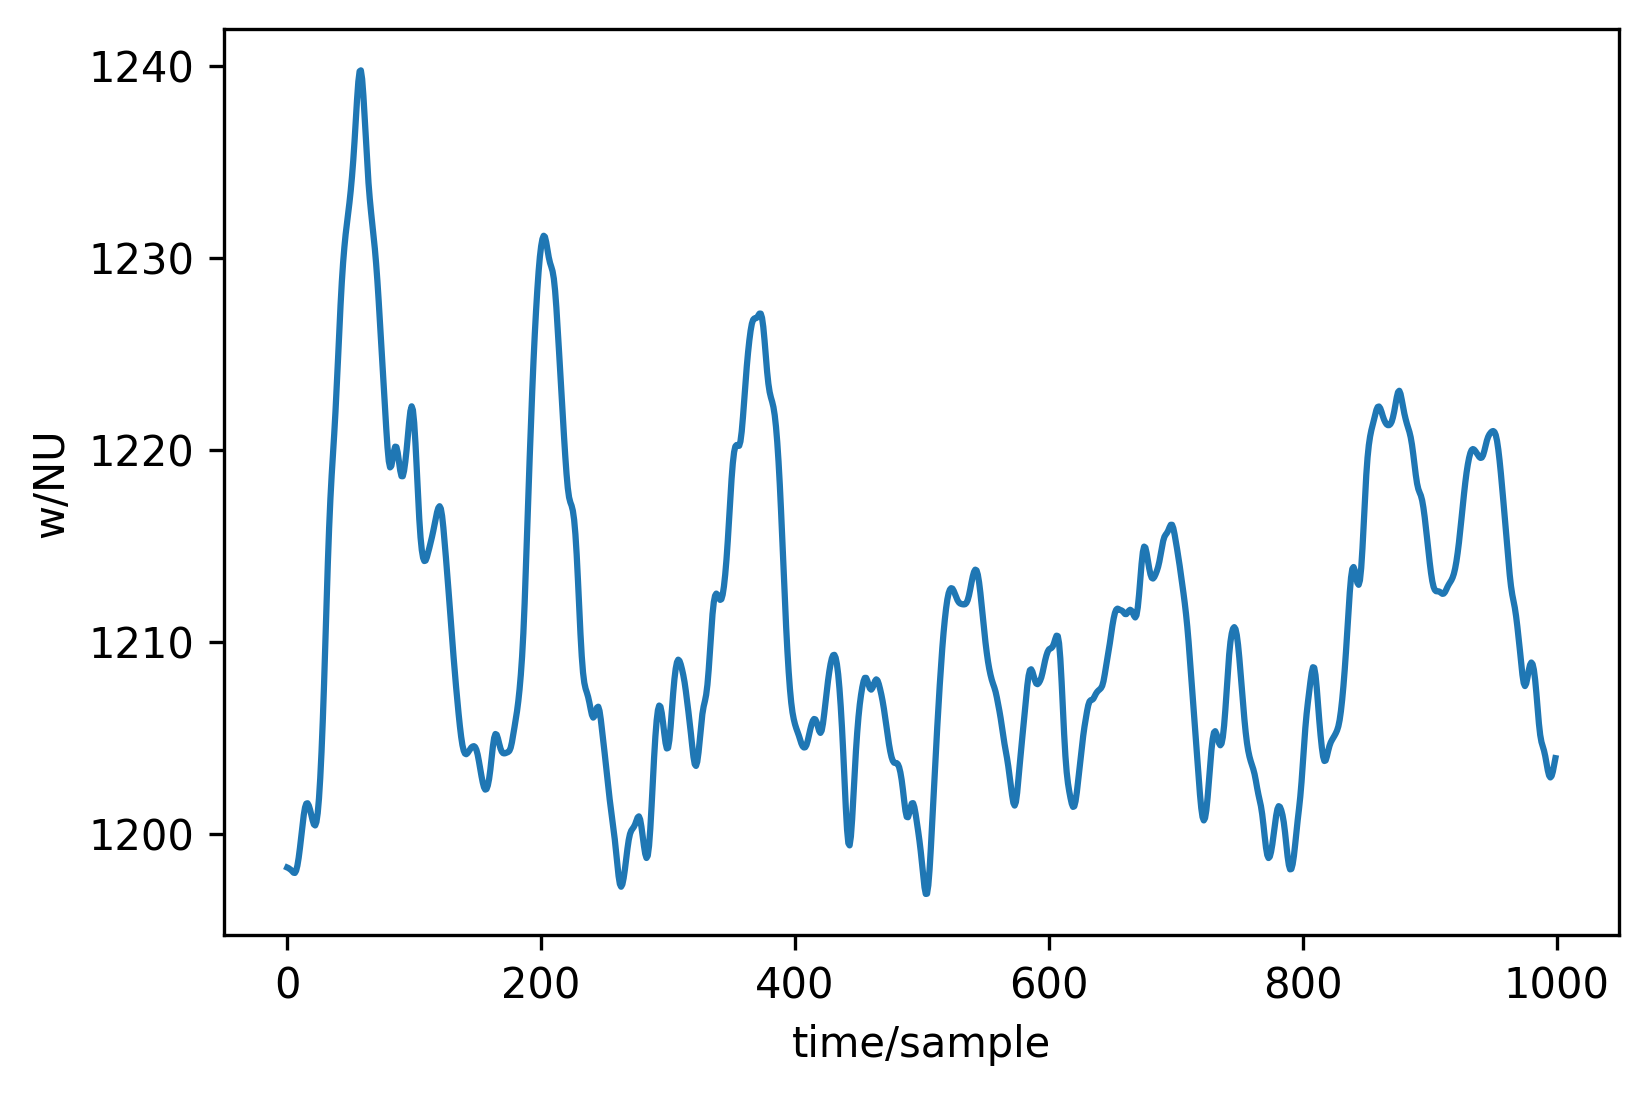

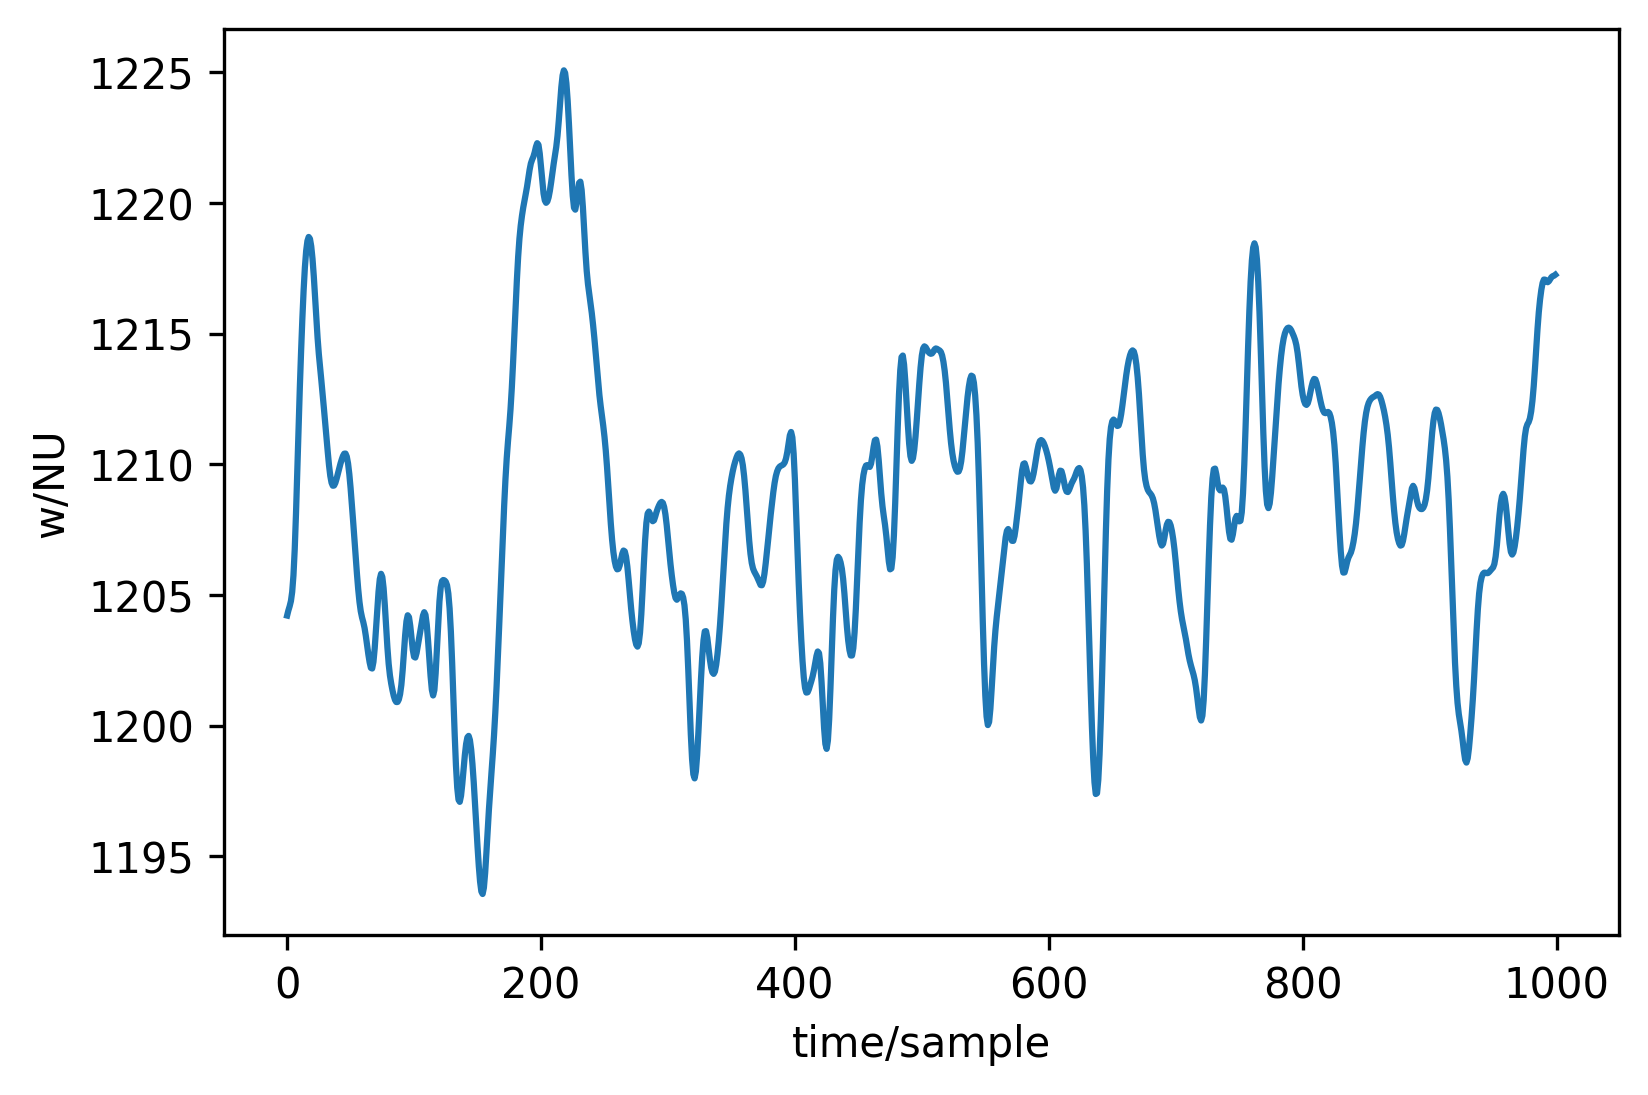

In [121]:
# let's look at some of the series

max=150785
max=20000
for i in range(0, max, 1000):
  displaySamples(i)

In [0]:
from scipy import signal

In [0]:
peaks = signal.find_peaks(data)

In [140]:
peaks[0]

array([ 11,  21,  38,  52,  63,  73,  95, 145, 159, 187, 309, 333, 353,
       388, 397, 419, 448, 454, 487, 525, 552, 608, 619, 680, 695, 730,
       739, 773, 787, 824, 842, 859, 887, 900, 937, 946, 983])

In [0]:
import heartpy as hp

In [0]:
type="s1_walk"

In [179]:

fullDataRecord = record = wfdb.rdrecord(type, pb_dir='wrist')
fullData = fullDataRecord.p_signal[:,0]
fullData.shape

(150529,)

In [0]:
# sample_rate = hp.get_samplerate_mstimer(timer)

In [185]:
sample_rate

402800.0

In [0]:
data, timer = hp.load_exampledata(1)

In [194]:
len(data)

15000

In [183]:
hp.process(fullData, sample_rate=256.0)

BadSignalWarning: ignored

# HeartPy

In [0]:
import heartpy as hp
import matplotlib.pyplot as plt
import numpy as np

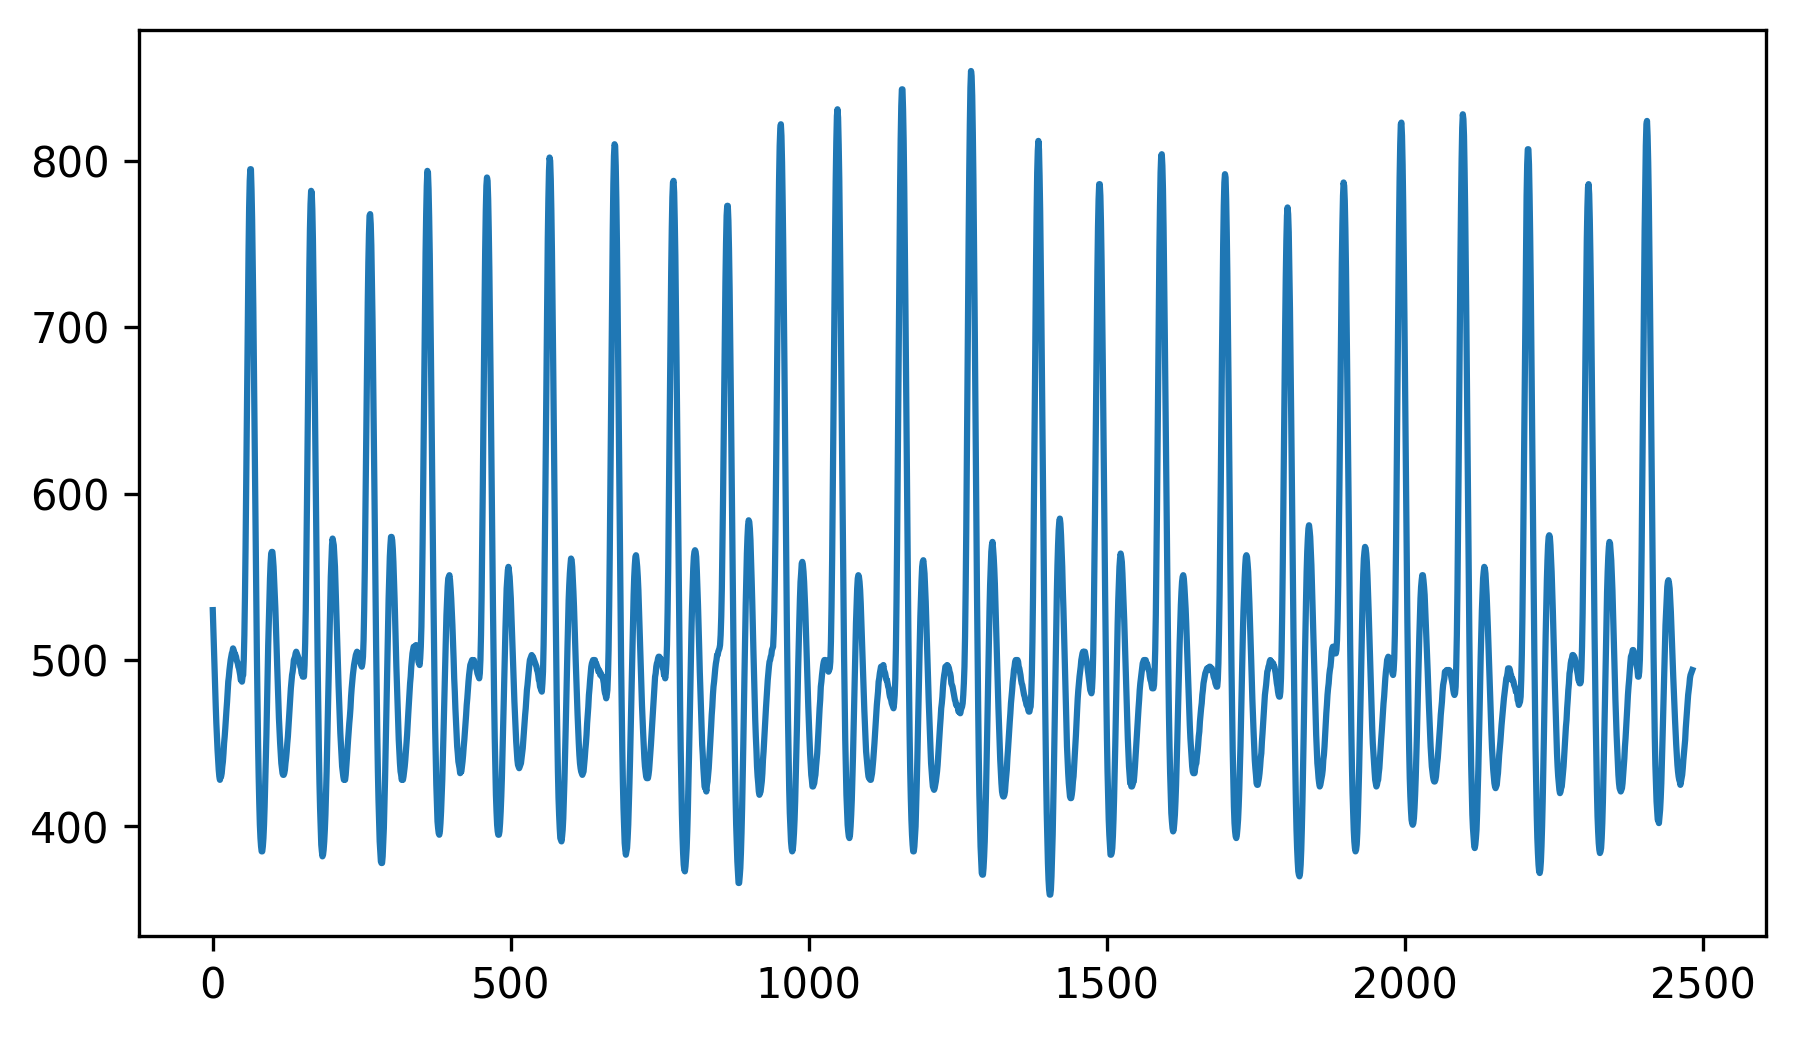

In [10]:
data, timer = hp.load_exampledata(0)

plt.figure(figsize=(7,4))
plt.plot(data)
plt.show()

## Detect peaks

We're detecting peaks from pre-processed PPG signal

=> this gives us Heart Rate values in BPM 

In [0]:
wd, m = hp.process(data, sample_rate = 100.0)

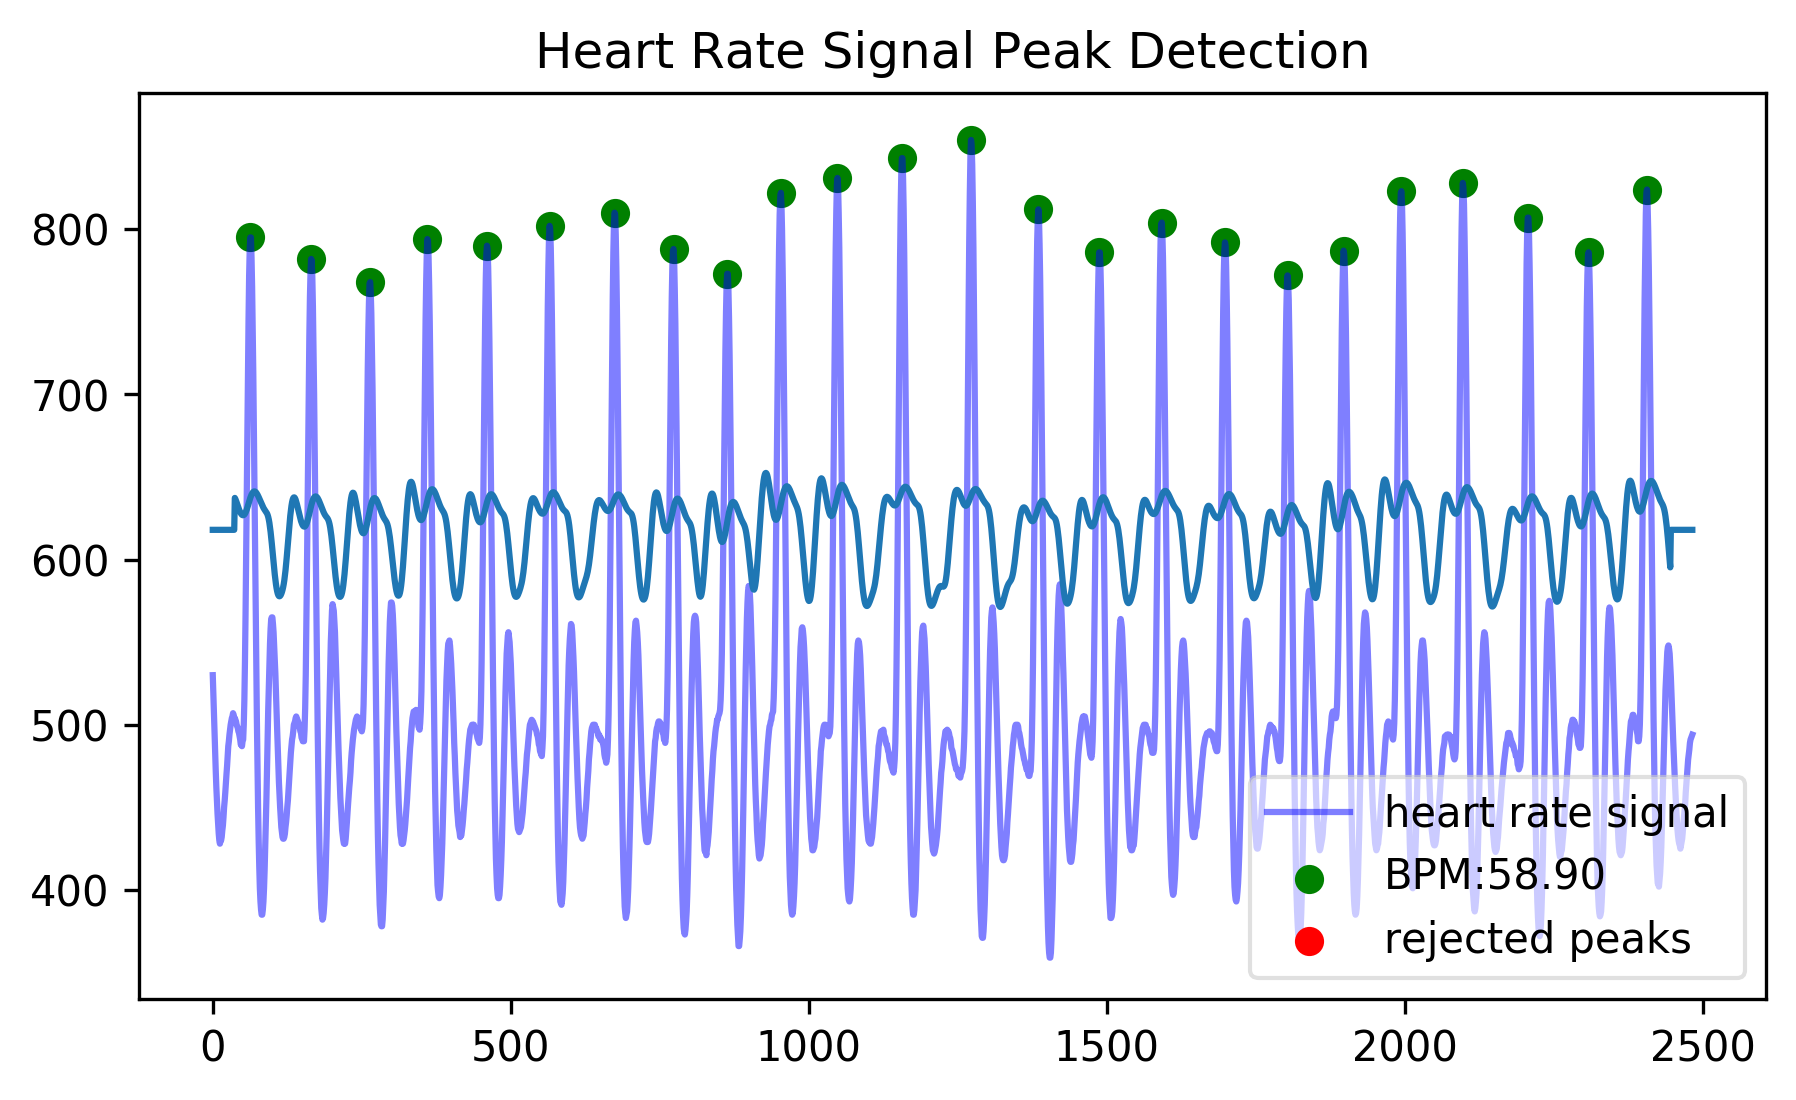

bpm: 58.898848
ibi: 1018.695652
sdnn: 65.760061
sdsd: 34.866925
rmssd: 64.737231
pnn20: 0.863636
pnn50: 0.409091
hr_mad: 40.000000
breathingrate: 0.161095


In [12]:
plt.figure(figsize=(7,4))

hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

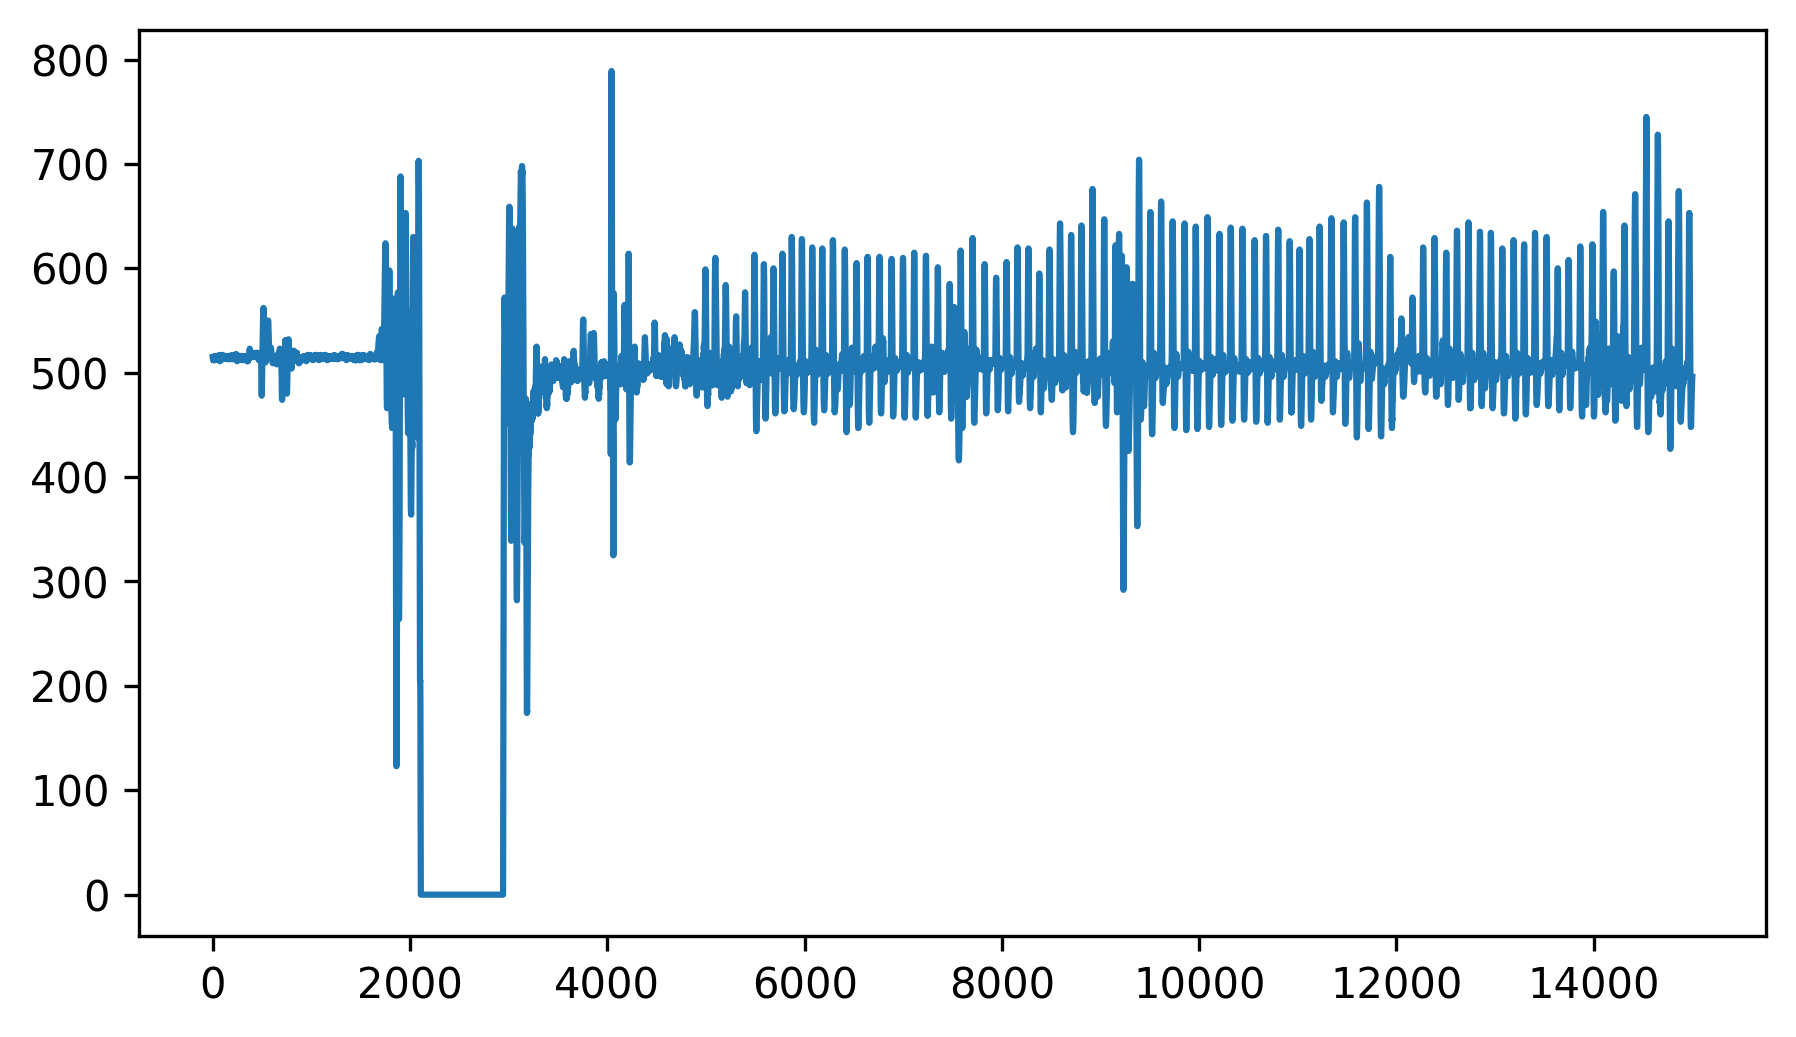

In [16]:
data, timer = hp.load_exampledata(1)

plt.figure(figsize=(7,4))
plt.plot(data)
plt.show()

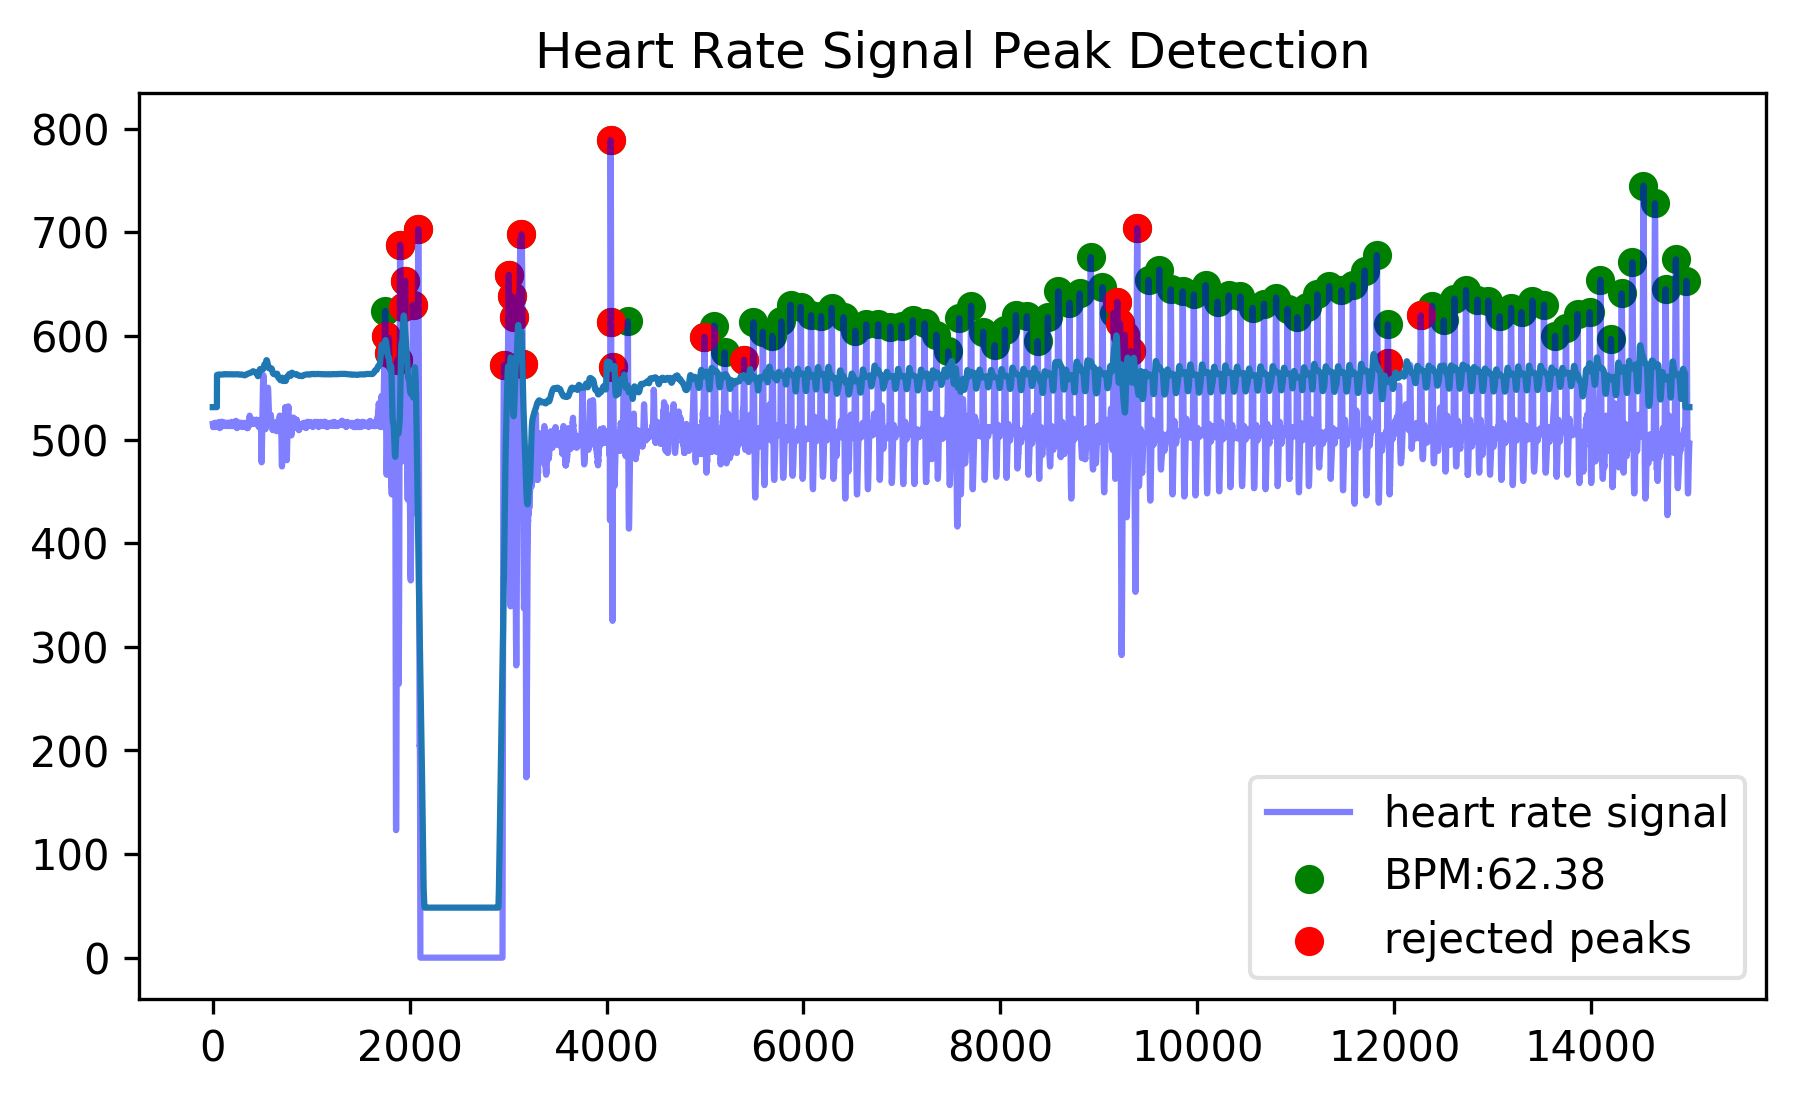

bpm: 62.376304
ibi: 961.903744
sdnn: 64.613519
sdsd: 29.871930
rmssd: 57.069746
pnn20: 0.797297
pnn50: 0.486486
hr_mad: 47.010333
breathingrate: 0.155994


In [17]:
sample_rate = hp.get_samplerate_mstimer(timer)

wd, m = hp.process(data, sample_rate)

plt.figure(figsize=(7,4))
hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [20]:
np.array(data).shape

(15000,)

In [0]:
data, timer = hp.load_exampledata(2)

hp.process(np.array(data), sample_rate=100)

In [0]:
ed1 = hp.load_exampledata(0)

## Reimport

In [0]:
import wfdb
import heartpy as hp

## Wrist processing

In [0]:
wristDir = 'wrist'
wristPeople = [ "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s8"]
wristTypes = [
    "walk",
    "run",
    "low_resistance_bike",
    "high_resistance_bike"
]

combinations = [person + "_" + wristType for person in wristPeople for wristType in wristTypes]

In [3]:
combinations

['s1_walk',
 's1_run',
 's1_low_resistance_bike',
 's1_high_resistance_bike',
 's2_walk',
 's2_run',
 's2_low_resistance_bike',
 's2_high_resistance_bike',
 's3_walk',
 's3_run',
 's3_low_resistance_bike',
 's3_high_resistance_bike',
 's4_walk',
 's4_run',
 's4_low_resistance_bike',
 's4_high_resistance_bike',
 's5_walk',
 's5_run',
 's5_low_resistance_bike',
 's5_high_resistance_bike',
 's6_walk',
 's6_run',
 's6_low_resistance_bike',
 's6_high_resistance_bike',
 's7_walk',
 's7_run',
 's7_low_resistance_bike',
 's7_high_resistance_bike',
 's8_walk',
 's8_run',
 's8_low_resistance_bike',
 's8_high_resistance_bike',
 's8_walk',
 's8_run',
 's8_low_resistance_bike',
 's8_high_resistance_bike']

In [6]:
records = []
for recordId in combinations:
  try:
    fullDataRecord = wfdb.rdrecord(recordId, pb_dir=wristDir)
    fullData = fullDataRecord.p_signal[:,1]
    records.append(fullData)
    print(recordId)
    print(fullData.shape)
  except:
    print(recordId + " does not exist")

s1_walk
(150529,)
s1_run does not exist
s1_low_resistance_bike
(148225,)
s1_high_resistance_bike
(150785,)
s2_walk
(102145,)
s2_run does not exist
s2_low_resistance_bike
(87297,)
s2_high_resistance_bike
(105985,)
s3_walk
(73473,)
s3_run
(78593,)
s3_low_resistance_bike
(75265,)
s3_high_resistance_bike
(71937,)
s4_walk does not exist
s4_run
(74753,)
s4_low_resistance_bike does not exist
s4_high_resistance_bike does not exist
s5_walk does not exist
s5_run
(78849,)
s5_low_resistance_bike
(71681,)
s5_high_resistance_bike does not exist
s6_walk
(86017,)
s6_run
(77313,)
s6_low_resistance_bike
(71681,)
s6_high_resistance_bike does not exist
s7_walk does not exist
s7_run does not exist
s7_low_resistance_bike does not exist
s7_high_resistance_bike does not exist
s8_walk
(102913,)
s8_run
(73473,)
s8_low_resistance_bike does not exist
s8_high_resistance_bike does not exist
s8_walk
(102913,)
s8_run
(73473,)
s8_low_resistance_bike does not exist
s8_high_resistance_bike does not exist


In [9]:
for record in records:
  hp.process(record, sample_rate=256)

BadSignalWarning: ignored

## BIDMC PPG + respiration

In [0]:
# test
bidmcDir = 'bidmc'
fullDataRecord = wfdb.rdrecord("bidmc01", pb_dir=bidmcDir)

In [3]:
fullDataRecord

In [0]:

bidmcPeople = map(lambda n: f'{n}'.zfill(2), range(0,53))
bidmcTypes = ["", "n"]

combinations = ["bidmc" + person + bidmcType for person in bidmcPeople for bidmcType in bidmcTypes]

In [0]:
combinations

In [0]:
recordsBidmc = []
for c in combinations:
  try:
    fullDataRecord = wfdb.rdrecord(c, pb_dir=bidmcDir)
    recordsBidmc.append(fullDataRecord)
    print(c)
    print(fullDataRecord.p_signal.shape)
  except:
    print(c + " does not exist")

In [0]:
bidmcWaveTypes = [""]
wave_combinations = ["bidmc" + person + bidmcType for person in bidmcPeople for bidmcType in bidmcTypes]

In [82]:
wave_combinations

[]

In [0]:
bidmc_people = map(lambda n: f'{n}'.zfill(2), range(0,53))
cc = list(bidmc_people)

In [0]:
cc = list(bidmc_people)


In [98]:
cc

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52']

In [100]:
records_waves_bidmc = []
for c in cc:
  try:
    fullDataRecord = wfdb.rdrecord("bidmc"+c, pb_dir=bidmcDir)
    records_waves_bidmc.append(fullDataRecord)
    print(c)
    print(fullDataRecord.p_signal.shape)
  except:
    print(c + " does not exist")

00 does not exist
01
(60001, 5)
02
(60001, 5)
03
(60001, 6)
04
(60001, 6)
05
(60001, 5)
06
(60001, 7)
07
(60001, 7)
08
(60001, 7)
09
(60001, 6)
10
(60001, 6)
11
(60001, 5)
12
(60001, 5)
13
(60001, 5)
14
(60001, 5)
15
(60001, 5)
16
(60001, 5)
17
(60001, 5)
18
(60001, 5)
19
(60001, 5)
20
(60001, 5)
21
(60001, 5)
22
(60001, 7)
23
(60001, 6)
24
(60001, 7)
25
(60001, 5)
26
(60001, 5)
27
(60001, 5)
28
(60001, 6)
29
(60001, 6)
30
(60001, 5)
31
(60001, 5)
32
(60001, 5)
33
(60001, 5)
34
(60001, 5)
35
(60001, 5)
36
(60001, 5)
37
(60001, 5)
38
(60001, 5)
39
(60001, 5)
40
(60001, 5)
41
(60001, 6)
42
(60001, 5)
43
(60001, 5)
44
(60001, 6)
45
(60001, 5)
46
(60001, 5)
47
(60001, 6)
48
(60001, 5)
49
(60001, 5)
50
(60001, 5)
51
(60001, 5)
52
(60001, 5)


In [8]:
recordsBidmc[0].__dict__

{'adc_gain': [65534.0, 138229.4494, 32670.9091, 42414.137, 32670.9091],
 'adc_res': [0, 0, 0, 0, 0],
 'adc_zero': [0, 0, 0, 0, 0],
 'base_counter': None,
 'base_date': None,
 'base_time': None,
 'baseline': [-32767, -63710, -16367, -11643, -16367],
 'block_size': [0, 0, 0, 0, 0],
 'byte_offset': [None, None, None, None, None],
 'checksum': [5854, 29272, -17810, -20589, 23277],
 'comments': ['<age>: 88 <sex>: M <location>: micu <source>: https://physionet.org/physiobank/database/mimic2wdb/matched/s01182/ <data segment>: 2688-03-25-23-14<modifications>: this is not a verbatim copy of an original file. Please see the accompanying LICENSE.txt file for further details.'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['bidmc01.dat',
  'bidmc01.dat',
  'bidmc01.dat',
  'bidmc01.dat',
  'bidmc01.dat'],
 'fmt': ['16', '16', '16', '16', '16'],
 'fs': 125,
 'init_value': [-9577, -3446, 801, 1248, 7335],
 'n_sig': 5,
 'p_signal': array([[0.35386

In [0]:
bidmcDir = 'bidmc'
fullDataRecord = wfdb.rdrecord("bidmc01", pb_dir=bidmcDir, sampfrom=1000, sampto=2000)

In [35]:
ppgData = fullDataRecord.p_signal[:, 2]
ppgData.shape

(1000,)

In [0]:
wd, m = hp.process(ppgData, sample_rate=125)

In [44]:
m['bpm']

93.94572025052193

In [0]:
diff = 1000

bpms = []
for n in range(0, 60000, diff):
  dataRec = wfdb.rdrecord("bidmc01", pb_dir=bidmcDir, sampfrom=n, sampto=n+diff)
  ppgData = dataRec.p_signal[:, 2]
  wd, m = hp.process(ppgData, sample_rate=125)
  print(m['bpm'])
  bpms.append(m['bpm'])

In [0]:
diff = 1000

hrvs = []
for n in range(0, 60000, diff):
  dataRec = wfdb.rdrecord("bidmc" + c, pb_dir=bidmcDir, sampfrom=n, sampto=n+diff)
  ppgData = dataRec.p_signal[:, 2]
  wd, m = hp.process(ppgData, sample_rate=125)
  print(m['rmssd'])
  hrvs.append(m['rmssd'])

In [0]:
import numpy as np

In [0]:
bpms_clear = list(filter(lambda x: not math.isnan(x), bpms))

In [72]:
np.mean(np.array(bpms_clear))

162.39134548846556

### Now all - mean

In [0]:
cc

In [0]:
cc[1:]

In [0]:
len(records_waves_bidmc)
diff = 1000
problems = 0
means = []
for c in cc[1:]:
  rec_bpms = []
  for n in range(0, 60000, diff):
    try:
      rec = wfdb.rdrecord("bidmc"+c, pb_dir=bidmcDir, sampfrom=n, sampto=n+diff)
      ppgData = rec.p_signal[:, 2]
      wd, m = hp.process(ppgData, sample_rate=125)
      rec_bpms.append(m['bpm'])
    except:
      problems += 1
      print("problem " + str(problems))
  bpms_clear = list(filter(lambda x: not math.isnan(x), rec_bpms))
  mean_bpm = np.mean(np.array(bpms_clear))
  print(mean_bpm)
  means.append(mean_bpm)

124.71519600020127


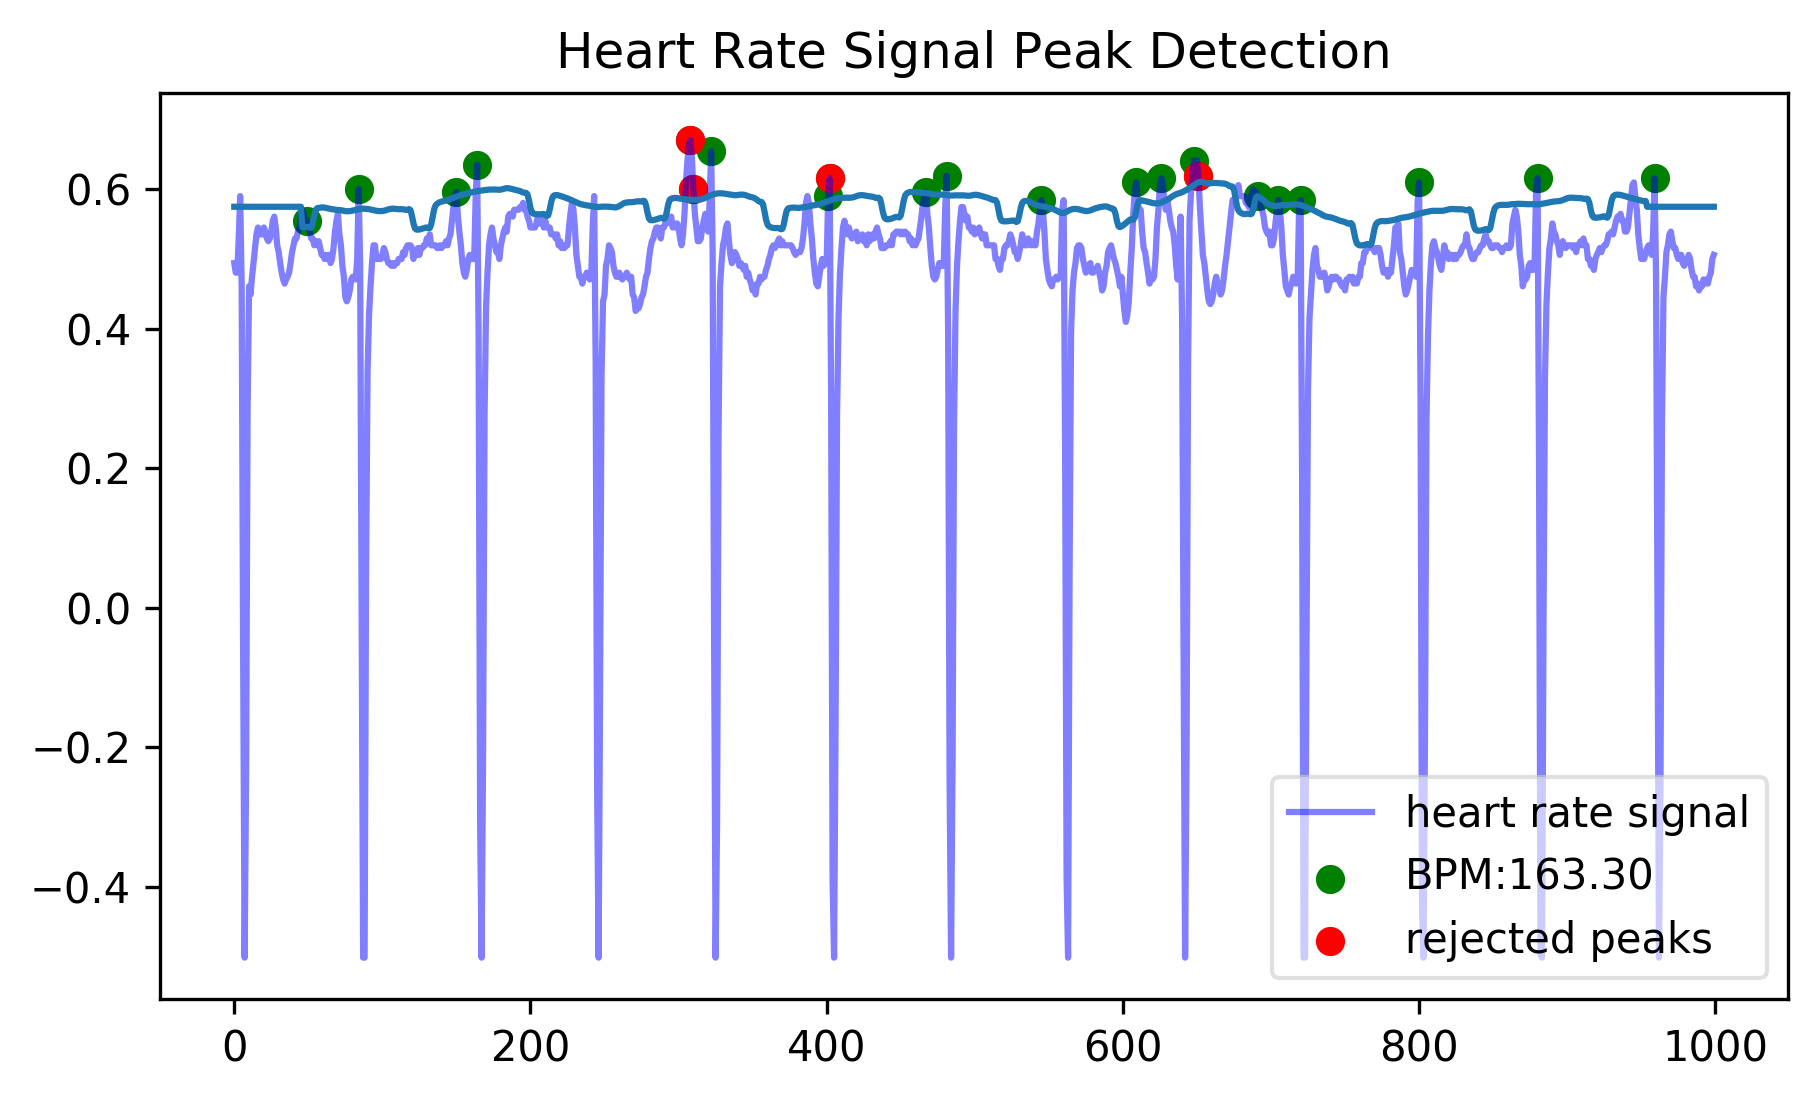

bpm: 163.297045
ibi: 367.428571
sdnn: 225.352332
sdsd: 200.409181
rmssd: 284.264665
pnn20: 0.600000
pnn50: 0.500000
hr_mad: 240.000000
breathingrate: 0.500000


In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))

hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [6]:
for recordBidmc in recordsBidmc:
  hp.process(recordBidmc, sample_rate=125)

TypeError: ignored